# Human Brain (Allen Brain)

In [1]:
%pylab inline

import warnings
warnings.filterwarnings("ignore")
import pickle
from SCCAF import *

Populating the interactive namespace from numpy and matplotlib


/nfs/leia/research/saraht/chichau/bin/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


> We use the `Tasic B. et al. Mouse neocortical areas` dataset to help the annotation.

In [2]:
adh = sc.read('processed/all_reg.h5')
adm = sc.read("mouse_2.h5")

> Find the ortholog between human and mouse, make a 1-to-1 matching.

In [3]:
genes = pd.read_csv("https://raw.githubusercontent.com/chichaumiau/scRNA_metadata/master/human2mouse.csv",\
                    index_col=0)
genes = genes[['Gene name','Mouse gene name']]
genes = genes.drop_duplicates('Gene name')
genes = genes.drop_duplicates('Mouse gene name')

In [4]:
adh = adh[:,adh.var_names.isin(genes['Gene name'])]
adm = adm[:,adm.var_names.isin(adh.var['mouse_homologenes-0'])]
adh = adh[:,adh.var['mouse_homologenes-0'].isin(adm.var_names)]

In [5]:
import copy
df = copy.copy(adh.var)
df['HumanGene'] = df.index
df.index = df['mouse_homologenes-0']

In [6]:
adh = adh[:,df.loc[adm.var_names]['HumanGene'].tolist()]

In [7]:
adm.shape

(21874, 14780)

In [8]:
adh.shape

(33782, 14780)

In [9]:
adm.write("mm.h5")
adh.write("hh.h5")

In [2]:
adm = sc.read("mm.h5")
adh = sc.read("hh.h5")

In [5]:
adm.obs.head(3).T

index                                                  F2S4_151217_005_B01  \
title                                                  F2S4_151217_005_B01   
source_name                                   Primary Visual Cortex (VISp)   
organism                                                      Mus musculus   
donor_id                                                            222454   
donor_sex                                                                M   
donor_genotype                        Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt   
injection_type                                                No Injection   
injection_target                                              No Injection   
injected_material                                             No Injection   
dissected_region                                                      VISp   
dissected_layer                                                       L2/3   
facs_gating                                                   RFP-positive   
facs_date                                                       12/17/2015   
rna_amplification_set                                       A8S4_160107_01   
sequencing_tube                                                   LS-14690   
sequencing_batch                                               R8S4-160203   
sequencing_qc_pass_fail                                               Pass   
cell_class                                                       GABAergic   
cell_subclass                                                        Pvalb   
cell_cluster                                                    Pvalb Tpbg   
molecule                                                         polyA RNA   
SRA_Run                                                         SRR7335406   
GEO_Sample                                                      GSM3189964   
GEO_Sample_Title         VISp_Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt_No I...   
n_genes                                                               8542   
n_counts                                                       1.28265e+06   

index                                                  F2S4_151217_005_C01  \
title                                                  F2S4_151217_005_C01   
source_name                                   Primary Visual Cortex (VISp)   
organism                                                      Mus musculus   
donor_id                                                            222454   
donor_sex                                                                M   
donor_genotype                        Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt   
injection_type                                                No Injection   
injection_target                                              No Injection   
injected_material                                             No Injection   
dissected_region                                                      VISp   
dissected_layer                                                       L2/3   
facs_gating                                                   RFP-positive   
facs_date                                                       12/17/2015   
rna_amplification_set                                       A8S4_160107_01   
sequencing_tube                                                   LS-14690   
sequencing_batch                                               R8S4-160203   
sequencing_qc_pass_fail                                               Pass   
cell_class                                                   Glutamatergic   
cell_subclass                                                           L4   
cell_cluster                                              L4 IT VISp Rspo1   
molecule                                                         polyA RNA   
SRA_Run                                                         SRR7335517   
GEO_Sample                                                      GSM3189964   
GEO_Sample_Title     

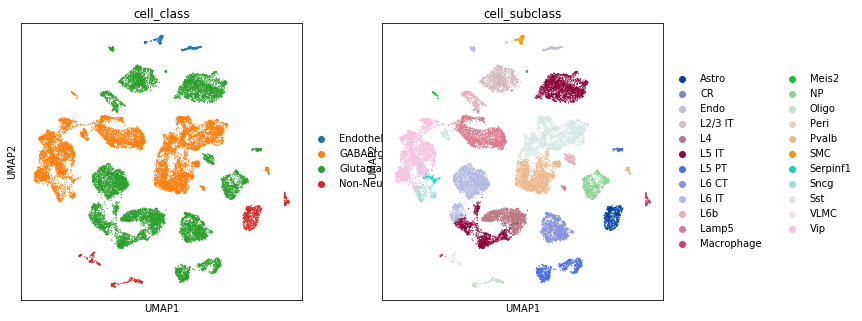

In [9]:
sc.pl.umap(adm, color=['cell_class','cell_subclass'])

> train logistic regression models on the mouse data.

In [26]:
clf = LogisticRegression(random_state=1, penalty='l1', C=0.5)
clf.fit(adm.X, adm.obs['cell_class'])

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [27]:
with open('class.pickle', 'wb') as handle:
    pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
adh.obs['class'] = clf.predict(adh.X)

In [121]:
clf = LogisticRegression(random_state=1, penalty='l1', C=0.5)
clf.fit(adm.X, adm.obs['cell_subclass'])

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [29]:
with open('subclass.pickle', 'wb') as handle:
    pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
adh.obs['subclass'] = clf.predict(adh.X)

In [17]:
adh.uns['subclass_colors'] = color_long

> use the projection from mouse data to separate the cell `class` (GATAergic, Glutamatergic, Non-Neuronal).

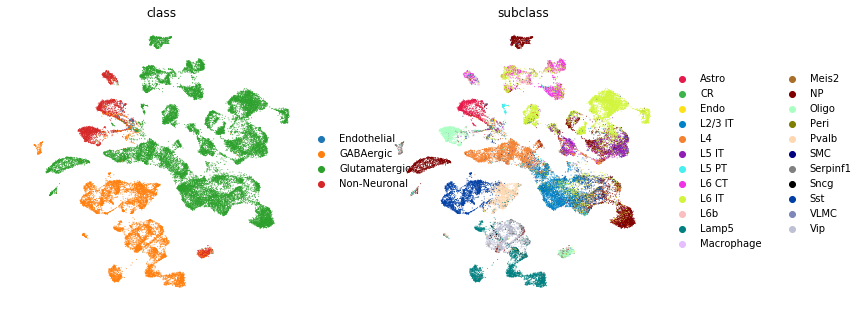

In [10]:
figsize(5,5)
sc.pl.umap(adh, color=['class','subclass'],frameon=False)

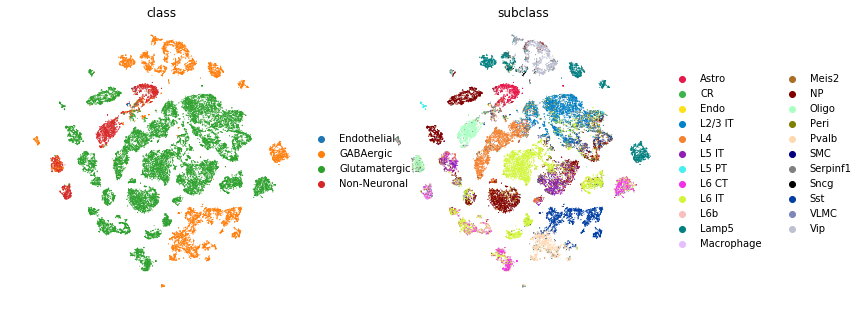

In [11]:
figsize(5,5)
sc.pl.tsne(adh, color=['class','subclass'],frameon=False)

In [39]:
sc.tl.louvain(adh, resolution=0.02)

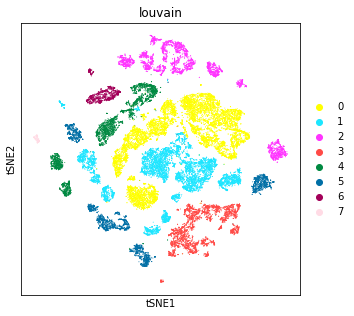

In [40]:
figsize(5,5)
sc.pl.tsne(adh, color=['louvain'])

> map the projection to louvain clustering.

In [59]:
mat = get_connection_matrix(adh.obs, 'louvain', 'class')
ad_obs = adh.obs
key1 = 'louvain'
key2 = 'class'
df = ad_obs.groupby([key1,key2]).size().to_frame().reset_index()
df.columns = [key1,key2,'counts']
df2 = ad_obs[key1].value_counts()
df['size'] = df2[df[key1].tolist()].tolist()
df['percent'] = df['counts']/df['size']
df = df[df['percent']>0.2]

In [101]:
df

louvain          class  counts   size   percent
2        0  Glutamatergic   10138  10226  0.991394
6        1  Glutamatergic    7984   8033  0.993900
8        2      GABAergic    4080   4080  1.000000
9        3      GABAergic    3613   3613  1.000000
13       4   Non-Neuronal    2694   3409  0.790261
15       5  Glutamatergic    3248   3250  0.999385
18       6  Glutamatergic    1026   1033  0.993224
19       7      GABAergic     138    138  1.000000

In [108]:
adh.obs['ann'] = adh.obs['louvain']
adh.obs['ann'].cat.categories = make_unique(df['class'])
adh.obs['ann'] = adh.obs['ann'].str.split('_').str[0]

... storing 'ann' as categorical


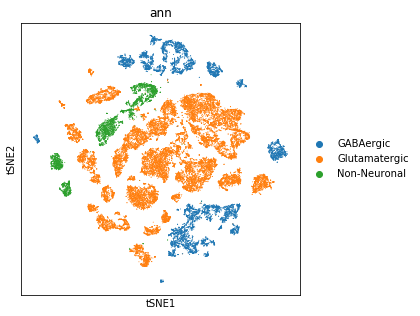

In [109]:
figsize(5,5)
sc.pl.tsne(adh, color=['ann'])

> the separation is `perfect`:

Mean CV accuracy: 0.9967
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.9931


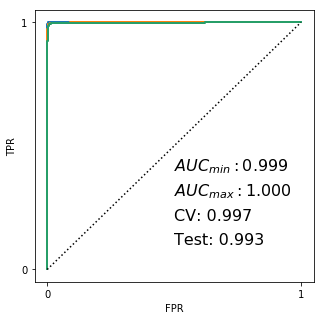

In [111]:
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adh.obsm['X_pca'], adh.obs['ann'],n=100)
aucs = plot_roc(y_prob, y_test, clf, cvsm=cvsm, acc=acc)
plt.show()

In [113]:
mkdir human

# Split and annotate each cell `class`.

In [114]:
for i in adh.obs['ann'].unique():
    ad = adh[adh.obs['ann']==i,:]
    ad.write("human/human_%s.h5"%i)

In [115]:
adh.obs['ann'].unique()

[GABAergic, Non-Neuronal, Glutamatergic]
Categories (3, object): [GABAergic, Non-Neuronal, Glutamatergic]

# Clustering
## GABAergic

In [116]:
ad = sc.read("human/human_GABAergic.h5")

In [122]:
ad.obs['subclass'] = clf.predict(ad.X)

... storing 'subclass' as categorical


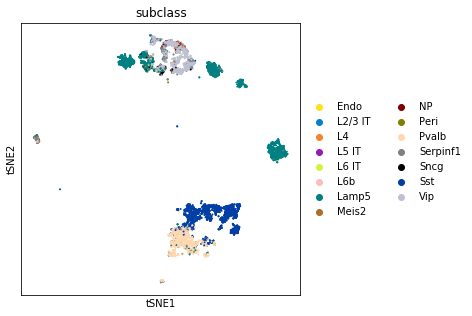

In [123]:
sc.pl.tsne(ad, color=['subclass'])

In [124]:
sc.tl.pca(ad, svd_solver='arpack')
sc.pp.neighbors(ad)
sc.tl.tsne(ad)

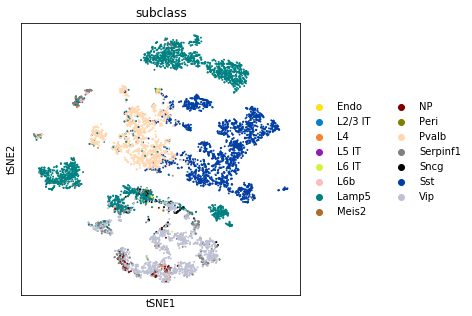

In [127]:
sc.pl.tsne(ad, color=['subclass'])

In [131]:
sc.tl.louvain(ad, resolution=1, key_added='louvain_r1')
sc.tl.louvain(ad, resolution=0.5, key_added='louvain_r0.5')
sc.tl.louvain(ad, resolution=0.05, key_added='louvain_r0.05')
sc.tl.louvain(ad, resolution=0.2, key_added='louvain_r0.2')
sc.tl.louvain(ad, resolution=0.3, key_added='louvain_r0.3')

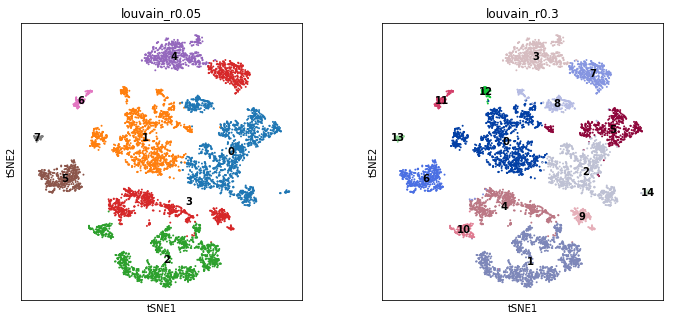

In [142]:
sc.pl.tsne(ad, color=['louvain_r0.05','louvain_r0.3'],legend_loc='on data')

In [143]:
ad.obs['L1_Round0'] = ad.obs['louvain_r0.3']

start_iter: 0
R1norm_cutoff: 0.500000
Accuracy: 0.000000
Round1 ...
Mean CV accuracy: 0.9700
Accuracy on the training set: 0.9951
Accuracy on the hold-out set: 0.9759


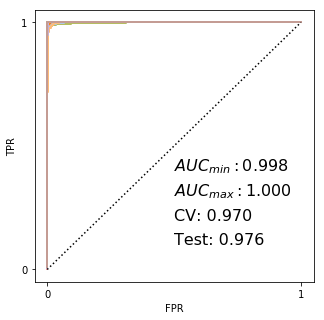

... storing 'L1_Round0_self-projection' as categorical


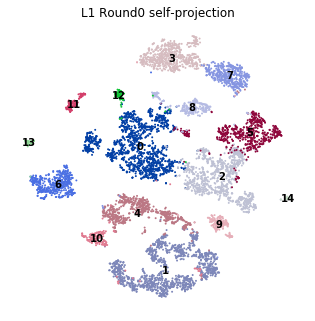

Accuracy on the training set: 0.9911
Accuracy on the hold-out set: 0.9732
Accuracy on the training set: 0.9960
Accuracy on the hold-out set: 0.9669
Max R1mat: 0.181818


<Figure size 360x360 with 0 Axes>

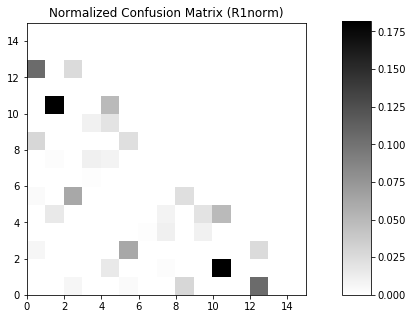

IGRAPH U-W- 15 0 --
+ attr: weight (e)
Converged!
c: 1
m1: 0.181818
Accuracy: 0.966950
start_iter: 0
R1norm_cutoff: 0.171818
Accuracy: 0.966950
Round1 ...
Mean CV accuracy: 0.9595
Accuracy on the training set: 0.9895
Accuracy on the hold-out set: 0.9741


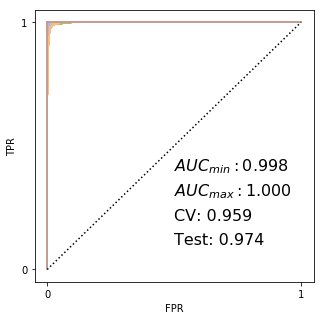

... storing 'L1_Round0_self-projection' as categorical


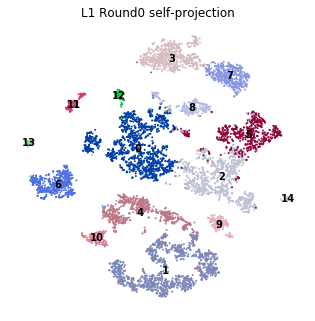

Accuracy on the training set: 0.9903
Accuracy on the hold-out set: 0.9689
Accuracy on the training set: 0.9960
Accuracy on the hold-out set: 0.9694
Max R1mat: 0.086420


<Figure size 360x360 with 0 Axes>

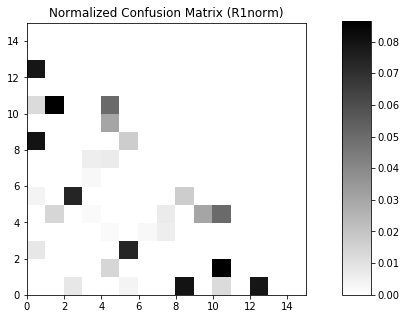

IGRAPH U-W- 15 0 --
+ attr: weight (e)
Converged!
c: 3
m1: 0.086420
Accuracy: 0.968921
start_iter: 0
R1norm_cutoff: 0.076420
Accuracy: 0.968921
Round1 ...
Mean CV accuracy: 0.9749
Accuracy on the training set: 0.9919
Accuracy on the hold-out set: 0.9695


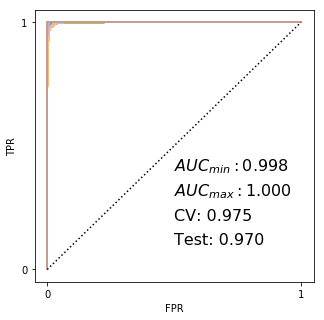

... storing 'L1_Round0_self-projection' as categorical


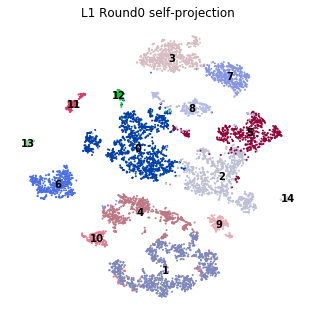

Accuracy on the training set: 0.9943
Accuracy on the hold-out set: 0.9723
Accuracy on the training set: 0.9927
Accuracy on the hold-out set: 0.9697
Max R1mat: 0.113924


<Figure size 360x360 with 0 Axes>

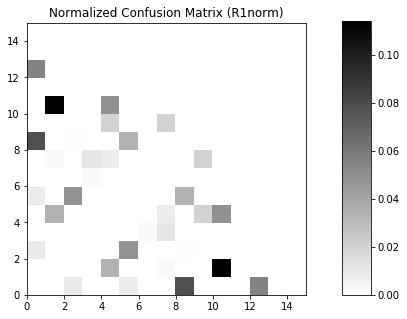

... storing 'L1_Round1' as categorical


IGRAPH U-W- 15 4 --
+ attr: weight (e)
+ edges:
0--8 1--10 0--8 1--10


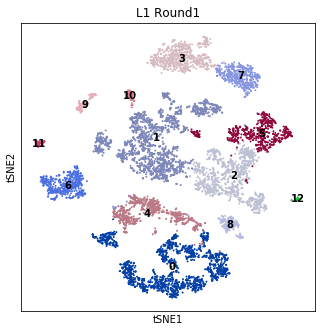

Round2 ...
Mean CV accuracy: 0.9754
Accuracy on the training set: 0.9943
Accuracy on the hold-out set: 0.9647


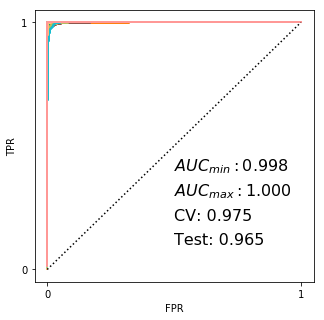

... storing 'L1_Round1_self-projection' as categorical


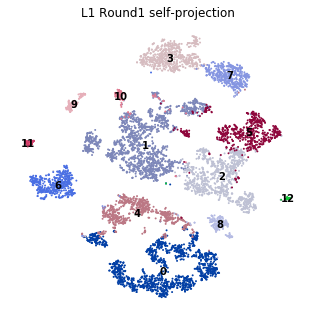

Accuracy on the training set: 0.9943
Accuracy on the hold-out set: 0.9643
Accuracy on the training set: 0.9924
Accuracy on the hold-out set: 0.9700
Max R1mat: 0.189189


<Figure size 360x360 with 0 Axes>

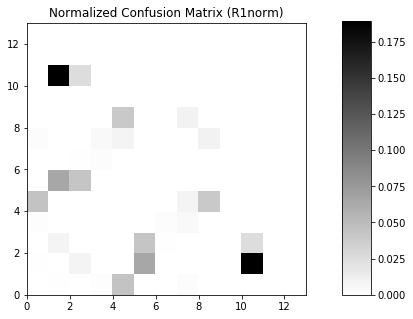

... storing 'L1_Round2' as categorical


IGRAPH U-W- 13 2 --
+ attr: weight (e)
+ edges:
1--10 1--10


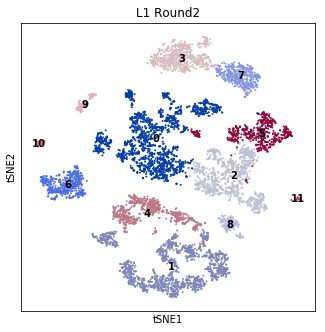

Round3 ...
Mean CV accuracy: 0.9685
Accuracy on the training set: 0.9931
Accuracy on the hold-out set: 0.9731


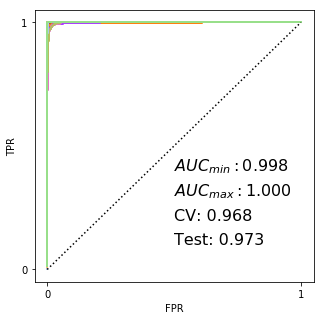

... storing 'L1_Round2_self-projection' as categorical


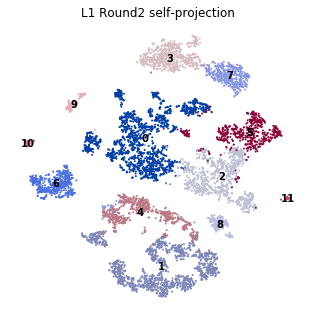

Accuracy on the training set: 0.9902
Accuracy on the hold-out set: 0.9695
Accuracy on the training set: 0.9951
Accuracy on the hold-out set: 0.9660
Max R1mat: 0.053785


<Figure size 360x360 with 0 Axes>

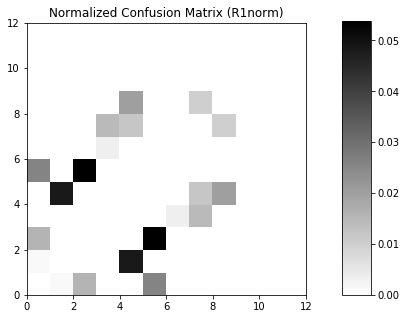

IGRAPH U-W- 12 0 --
+ attr: weight (e)
Converged!
m1: 0.053785
Accuracy: 0.965957
start_iter: 2
R1norm_cutoff: 0.043785
Accuracy: 0.965957
Round3 ...
Mean CV accuracy: 0.9655
Accuracy on the training set: 0.9892
Accuracy on the hold-out set: 0.9661


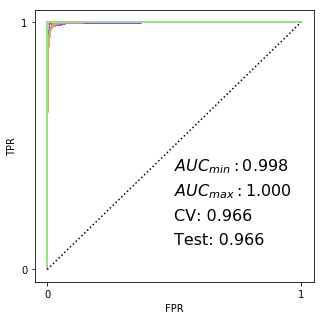

... storing 'L1_Round2_self-projection' as categorical


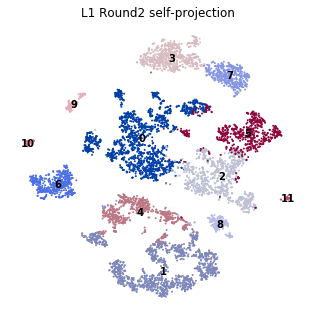

Accuracy on the training set: 0.9931
Accuracy on the hold-out set: 0.9746
Accuracy on the training set: 0.9921
Accuracy on the hold-out set: 0.9702
Max R1mat: 0.045545


<Figure size 360x360 with 0 Axes>

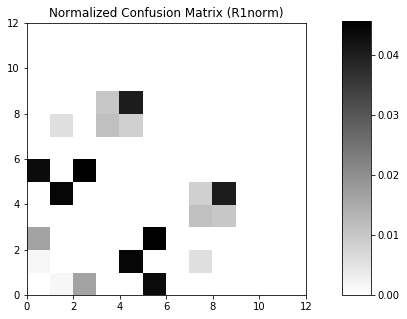

... storing 'L1_Round3' as categorical


IGRAPH U-W- 12 2 --
+ attr: weight (e)
+ edges:
2--5 2--5


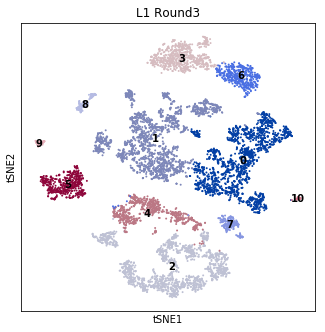

Round4 ...
Mean CV accuracy: 0.9848
Accuracy on the training set: 0.9956
Accuracy on the hold-out set: 0.9744


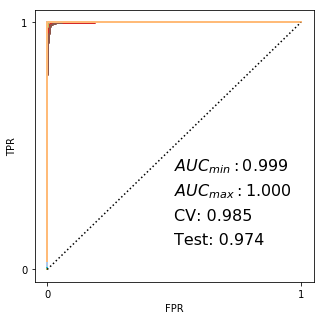

... storing 'L1_Round3_self-projection' as categorical


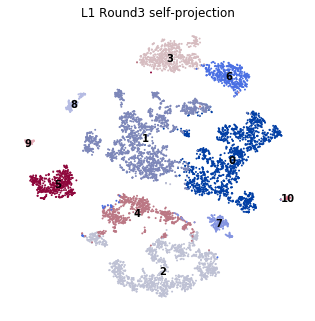

Accuracy on the training set: 0.9967
Accuracy on the hold-out set: 0.9728
Accuracy on the training set: 0.9967
Accuracy on the hold-out set: 0.9774
Max R1mat: 0.080808
Converge1!
m1: 0.080808
Accuracy: 0.972813


In [149]:
SCCAF_optimize_all_V2(min_acc=0.97, ad=ad, use='pca', basis='tsne',key1 = 'louvain_r0.05')

In [150]:
ad.write("human/human_GABAergic_reg.h5")

In [12]:
ad = sc.read("human/human_GABAergic_reg.h5")

In [14]:
ad.uns['L1_result_colors'] = default_20

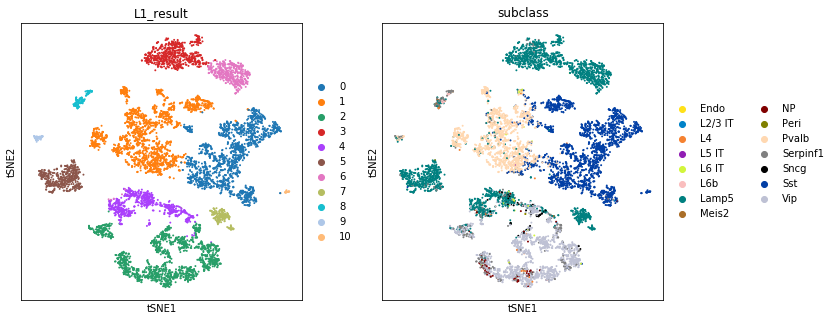

In [15]:
sc.pl.tsne(ad, color=['L1_result','subclass'])

> the data projection result is not ideal.

Mean CV accuracy: 0.7611
Accuracy on the training set: 0.9984
Accuracy on the hold-out set: 0.8858


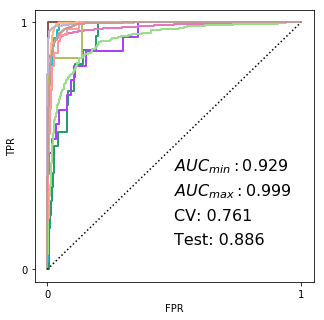

In [16]:
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(ad.X, ad.obs['subclass'],n=100)
aucs = plot_roc(y_prob, y_test, clf, cvsm=cvsm, acc=acc)
plt.show()

> the SCCAF optimized result shows better discrimination.

Mean CV accuracy: 0.9815
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.9776


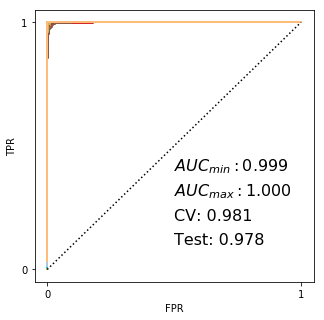

In [30]:
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(ad.X, ad.obs['L1_result'],n=100)
aucs = plot_roc(y_prob, y_test, clf, cvsm=cvsm, acc=acc)
plt.show()

In [33]:
topmarkers = get_topmarkers(clf, ad.var_names, topn=50)

In [32]:
mkdir markers

In [34]:
topmarkers.to_csv("markers/GABAergic_markers.csv")

In [35]:
topmarkers = get_topmarkers(clf, ad.var_names, topn=2)

In [36]:
topmarkers

cell_type      gene    weight
5339          0     GRIK1  0.448157
3437          0       DMD  0.380693
11835         1     SLIT2  0.686898
4393          1      FBN2  0.577595
8460         10       NPY  1.215314
8695          2     OLFM3  0.770511
2481          2       CIT  0.409388
803           3      ANO4  0.572806
6533          3       KIT  0.355396
7090          4     LUZP2  0.708263
2651          4      CNR1  0.647867
2453          5     CHST9  0.957654
9145          5     PDGFD  0.628539
4678          6     FRAS1  0.559204
8136          6      NDNF  0.470068
6036          7  IL1RAPL2  0.608274
3249          7      DDR2  0.497244
14682         8     ZFPM2  0.622801
952           8  ARHGAP24  0.483754
6826          9    LHFPL3  0.411979
5447          9     GULP1  0.290655

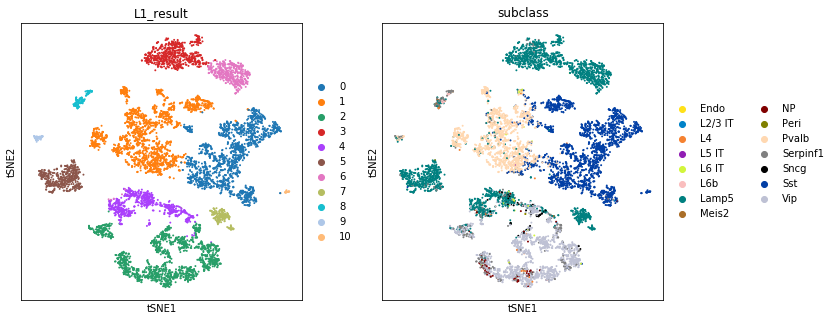

In [15]:
sc.pl.tsne(ad, color=['L1_result','subclass'])

In [24]:
key1 = 'L1_result'
key2 = 'subclass'
ad_obs = ad.obs
df = ad_obs.groupby([key1,key2]).size().to_frame().reset_index()
df.columns = [key1,key2,'counts']
df2 = ad_obs[key1].value_counts()
df['size'] = df2[df[key1].tolist()].tolist()
df['percent'] = df['counts']/df['size']
df = df[df['percent']>0.3]

In [25]:
df

L1_result  subclass  counts  size   percent
6          0       Sst    1679  1709  0.982446
11         1     Pvalb    1323  1807  0.732153
22         2       Vip    1196  1539  0.777128
23         3     Lamp5     682   699  0.975680
28         4     Lamp5     398   696  0.571839
35         5     Lamp5     474   494  0.959514
41         6     Lamp5     454   455  0.997802
42         7     Lamp5     196   197  0.994924
49         8  Serpinf1      78   138  0.565217
51         9     Pvalb      33    63  0.523810
53        10       Sst      34    34  1.000000

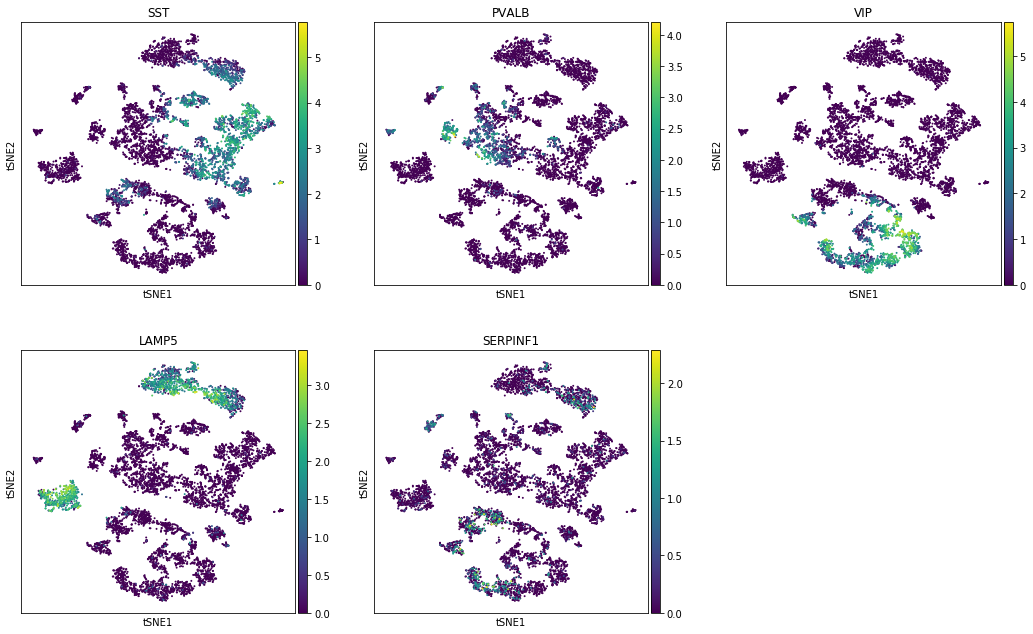

In [28]:
sc.pl.tsne(ad, color=['SST','PVALB','VIP','LAMP5','SERPINF1'], ncols=3)

|SCCAF|subclass|
|-|-|
|0|SST|
|1|PVALB|
|2|VIP|
|3|LAMP5|
|5|LAMP5|
|6|LAMP5|
|10|SST|

> combine the projection markers and the SCCAF extracted markers to annotate the `subclass`.

In [37]:
x = '''SST GRIK1
PVALB SLIT2
VIP OLFM3
LAMP5 ANO4
LUZP2
LAMP5 CHST9
LAMP5 FRAS1
IL1RAPL2
ZFPM2
LHFPL3
SST NPY'''.split('\n')

In [38]:
ad.obs['ann'] = ad.obs['L1_result']
ad.obs['ann'].cat.categories = x

In [40]:
ad.uns['ann_colors'] = default_20

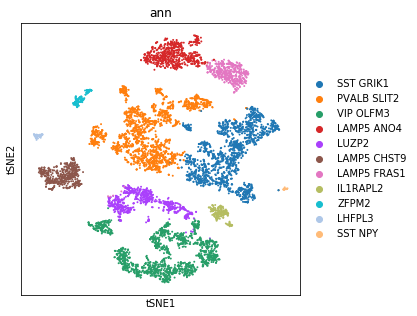

In [41]:
sc.pl.tsne(ad, color=['ann'])

In [42]:
ad.write("human/human_GABAergic_reg.h5")

## Glutamatergic

In [2]:
ad = sc.read("human/human_Glutamatergic.h5")

In [3]:
clf = pickle.load(open('subclass.pickle','rb'))
ad.obs['subclass'] = clf.predict(ad.X)

... storing 'subclass' as categorical


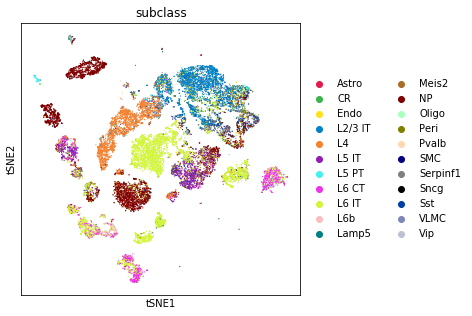

In [5]:
figsize(5,5)
sc.pl.tsne(ad, color=['subclass'])

In [6]:
sc.tl.pca(ad, svd_solver='arpack')
sc.pp.neighbors(ad)
sc.tl.tsne(ad)

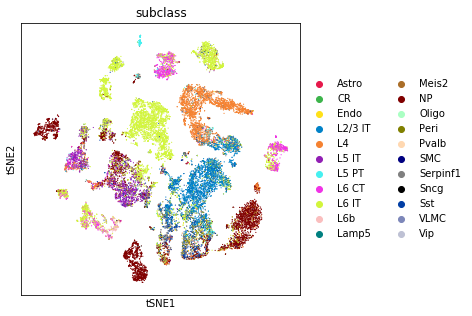

In [7]:
sc.pl.tsne(ad, color=['subclass'])

In [8]:
sc.tl.louvain(ad, resolution=0.05, key_added='louvain_r0.05')
sc.tl.louvain(ad, resolution=0.2, key_added='louvain_r0.2')
sc.tl.louvain(ad, resolution=0.3, key_added='louvain_r0.3')
sc.tl.louvain(ad, resolution=0.5, key_added='louvain_r0.5')
sc.tl.louvain(ad, resolution=1, key_added='louvain_r1')

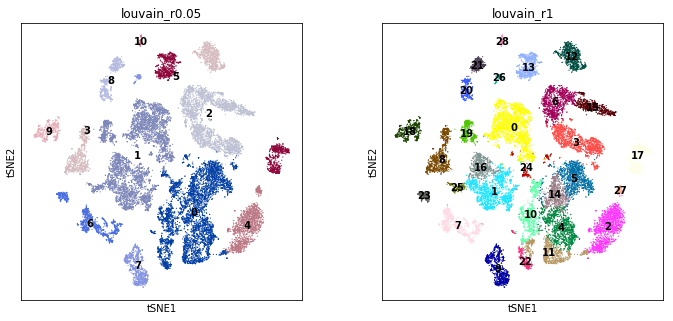

In [9]:
sc.pl.tsne(ad, color=['louvain_r0.05','louvain_r1'],legend_loc='on data')

In [10]:
ad.obs['L1_Round0'] = ad.obs['louvain_r1']

start_iter: 0
R1norm_cutoff: 0.500000
Accuracy: 0.000000
Round1 ...
Mean CV accuracy: 0.9579
Accuracy on the training set: 0.9809
Accuracy on the hold-out set: 0.9459


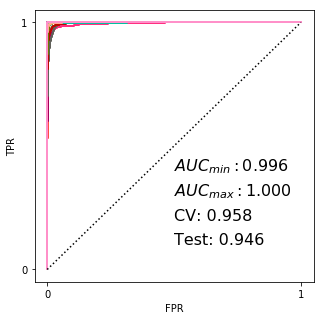

... storing 'L1_Round0_self-projection' as categorical


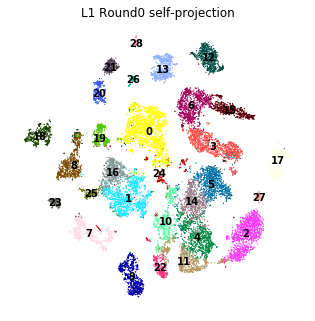

Accuracy on the training set: 0.9806
Accuracy on the hold-out set: 0.9446
Accuracy on the training set: 0.9780
Accuracy on the hold-out set: 0.9474
Max R1mat: 0.240385


<Figure size 360x360 with 0 Axes>

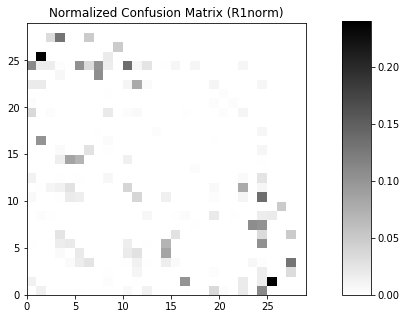

IGRAPH U-W- 29 0 --
+ attr: weight (e)
Converged!
c: 1
m1: 0.240385
Accuracy: 0.944599
start_iter: 0
R1norm_cutoff: 0.230385
Accuracy: 0.944599
Round1 ...
Mean CV accuracy: 0.9510
Accuracy on the training set: 0.9762
Accuracy on the hold-out set: 0.9490


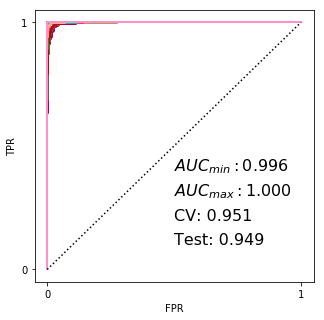

... storing 'L1_Round0_self-projection' as categorical


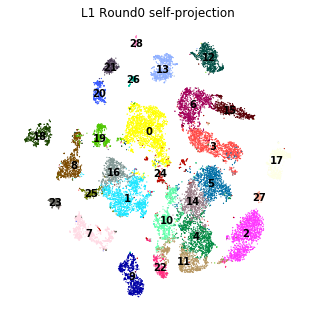

Accuracy on the training set: 0.9773
Accuracy on the hold-out set: 0.9453
Accuracy on the training set: 0.9827
Accuracy on the hold-out set: 0.9443
Max R1mat: 0.295238


<Figure size 360x360 with 0 Axes>

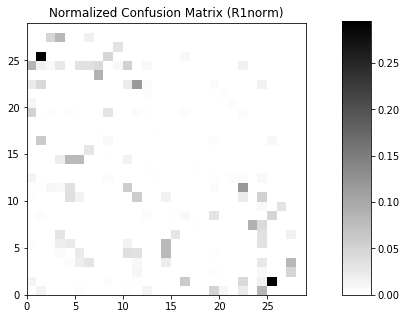

... storing 'L1_Round1' as categorical


IGRAPH U-W- 29 2 --
+ attr: weight (e)
+ edges:
1--25 1--25


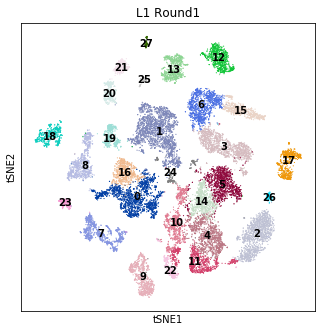

Round2 ...
Mean CV accuracy: 0.9522
Accuracy on the training set: 0.9791
Accuracy on the hold-out set: 0.9483


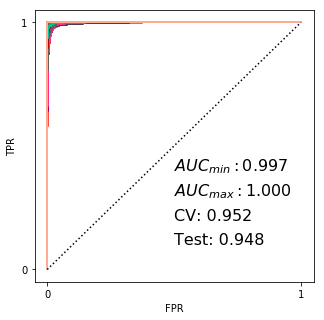

... storing 'L1_Round1_self-projection' as categorical


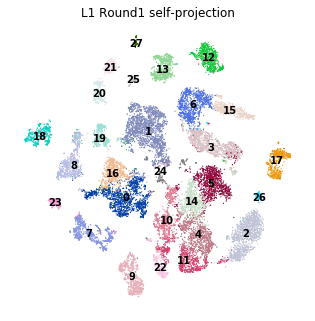

Accuracy on the training set: 0.9768
Accuracy on the hold-out set: 0.9488
Accuracy on the training set: 0.9847
Accuracy on the hold-out set: 0.9473
Max R1mat: 0.107394


<Figure size 360x360 with 0 Axes>

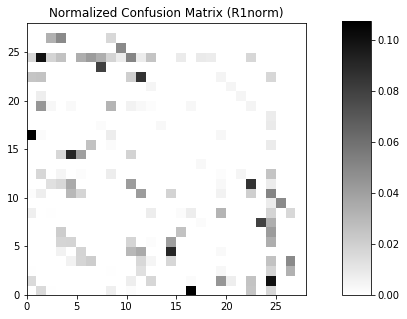

IGRAPH U-W- 28 0 --
+ attr: weight (e)
Converged!
m1: 0.107394
Accuracy: 0.947345
start_iter: 1
R1norm_cutoff: 0.097394
Accuracy: 0.947345
Round2 ...
Mean CV accuracy: 0.9567
Accuracy on the training set: 0.9836
Accuracy on the hold-out set: 0.9490


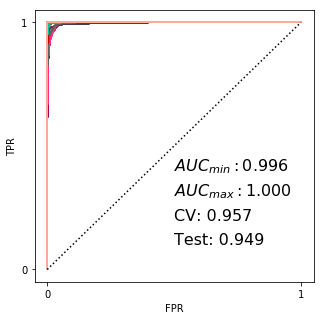

... storing 'L1_Round1_self-projection' as categorical


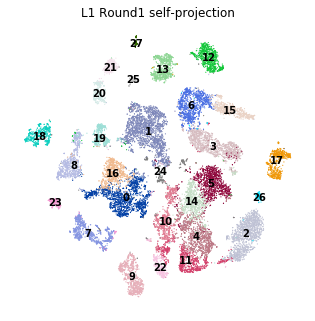

Accuracy on the training set: 0.9824
Accuracy on the hold-out set: 0.9506
Accuracy on the training set: 0.9806
Accuracy on the hold-out set: 0.9493
Max R1mat: 0.131148


<Figure size 360x360 with 0 Axes>

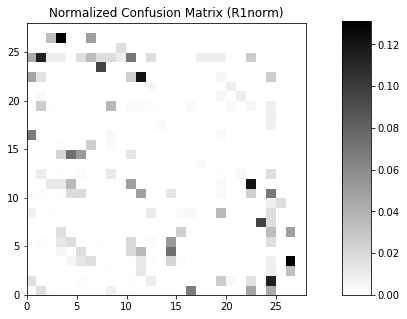

... storing 'L1_Round2' as categorical


IGRAPH U-W- 28 4 --
+ attr: weight (e)
+ edges:
1--24 11--22 11--22 1--24


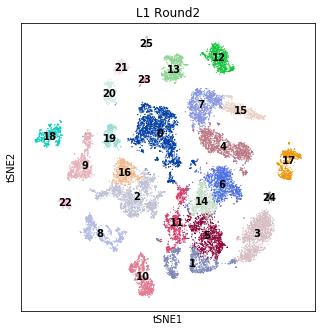

Round3 ...
Mean CV accuracy: 0.9556
Accuracy on the training set: 0.9814
Accuracy on the hold-out set: 0.9510


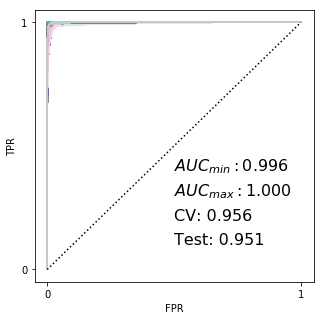

... storing 'L1_Round2_self-projection' as categorical


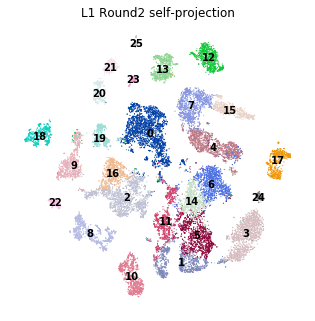

Accuracy on the training set: 0.9822
Accuracy on the hold-out set: 0.9484
Accuracy on the training set: 0.9822
Accuracy on the hold-out set: 0.9483
Max R1mat: 0.130824


<Figure size 360x360 with 0 Axes>

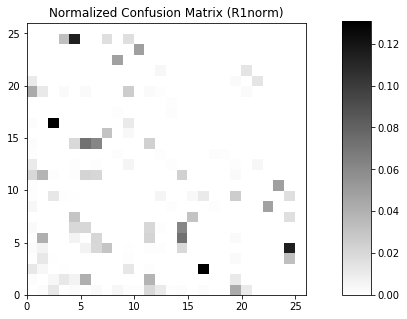

... storing 'L1_Round3' as categorical


IGRAPH U-W- 26 2 --
+ attr: weight (e)
+ edges:
2--16 2--16


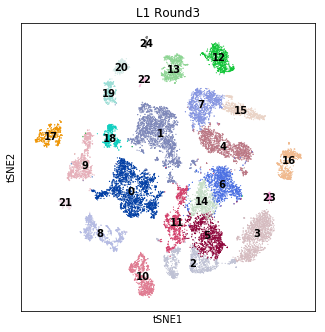

Round4 ...
Mean CV accuracy: 0.9655
Accuracy on the training set: 0.9853
Accuracy on the hold-out set: 0.9554


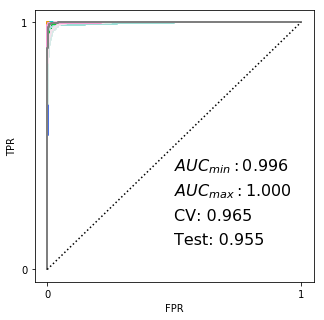

... storing 'L1_Round3_self-projection' as categorical


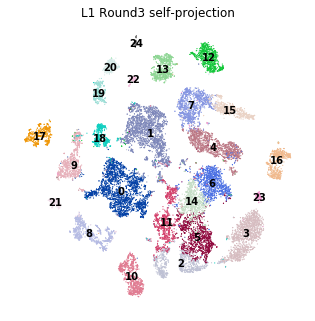

Accuracy on the training set: 0.9840
Accuracy on the hold-out set: 0.9520
Accuracy on the training set: 0.9836
Accuracy on the hold-out set: 0.9532
Max R1mat: 0.121951


<Figure size 360x360 with 0 Axes>

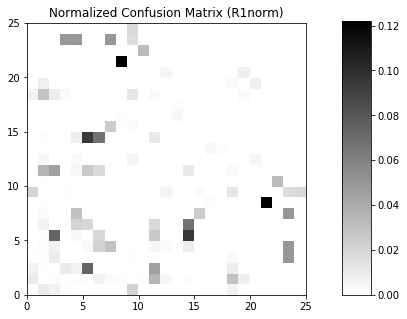

... storing 'L1_Round4' as categorical


IGRAPH U-W- 25 2 --
+ attr: weight (e)
+ edges:
8--21 8--21


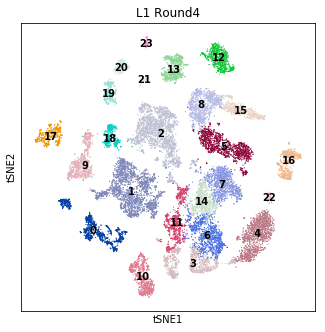

Round5 ...
Mean CV accuracy: 0.9596
Accuracy on the training set: 0.9846
Accuracy on the hold-out set: 0.9520


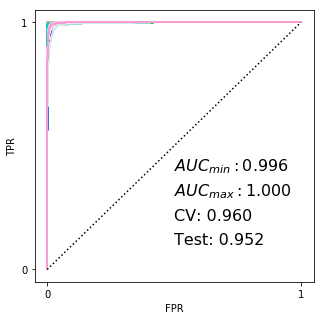

... storing 'L1_Round4_self-projection' as categorical


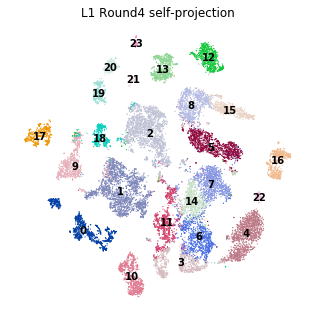

Accuracy on the training set: 0.9789
Accuracy on the hold-out set: 0.9546
Accuracy on the training set: 0.9833
Accuracy on the hold-out set: 0.9516
Max R1mat: 0.088285


<Figure size 360x360 with 0 Axes>

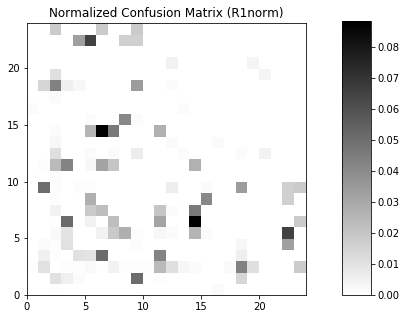

IGRAPH U-W- 24 0 --
+ attr: weight (e)
Converged!
m1: 0.088285
Accuracy: 0.951641
start_iter: 4
R1norm_cutoff: 0.078285
Accuracy: 0.951641
Round5 ...
Mean CV accuracy: 0.9600
Accuracy on the training set: 0.9855
Accuracy on the hold-out set: 0.9551


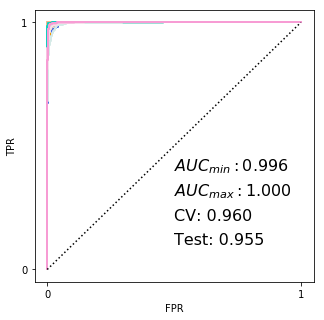

... storing 'L1_Round4_self-projection' as categorical


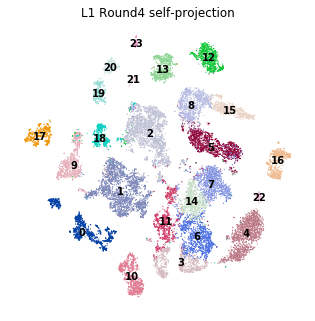

Accuracy on the training set: 0.9846
Accuracy on the hold-out set: 0.9565
Accuracy on the training set: 0.9842
Accuracy on the hold-out set: 0.9547
Max R1mat: 0.098361


<Figure size 360x360 with 0 Axes>

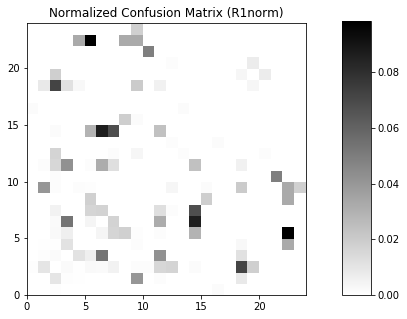

... storing 'L1_Round5' as categorical


IGRAPH U-W- 24 2 --
+ attr: weight (e)
+ edges:
6--14 6--14


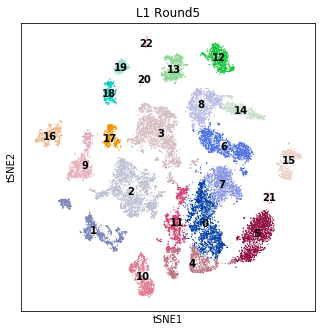

Round6 ...
Mean CV accuracy: 0.9614
Accuracy on the training set: 0.9835
Accuracy on the hold-out set: 0.9593


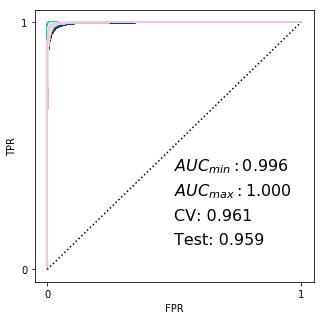

... storing 'L1_Round5_self-projection' as categorical


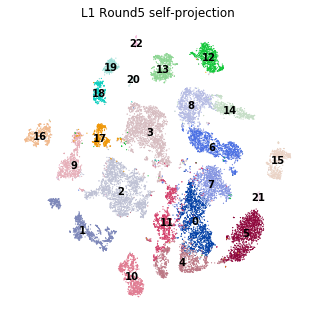

Accuracy on the training set: 0.9835
Accuracy on the hold-out set: 0.9563
Accuracy on the training set: 0.9894
Accuracy on the hold-out set: 0.9562
Max R1mat: 0.081967


<Figure size 360x360 with 0 Axes>

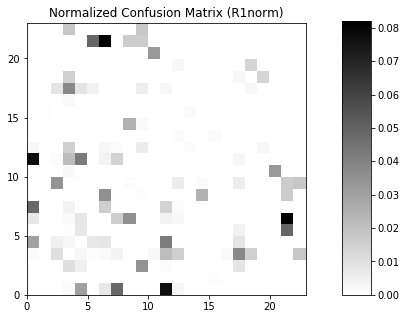

IGRAPH U-W- 23 0 --
+ attr: weight (e)
Converged!
m1: 0.081967
Accuracy: 0.956199
start_iter: 5
R1norm_cutoff: 0.071967
Accuracy: 0.956199
Round6 ...
Mean CV accuracy: 0.9582
Accuracy on the training set: 0.9802
Accuracy on the hold-out set: 0.9580


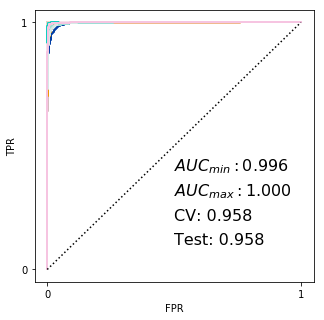

... storing 'L1_Round5_self-projection' as categorical


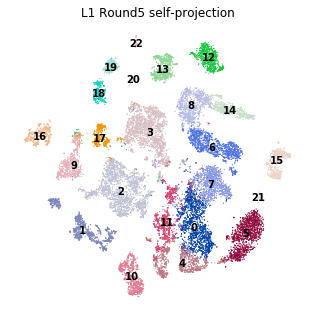

Accuracy on the training set: 0.9844
Accuracy on the hold-out set: 0.9561
Accuracy on the training set: 0.9867
Accuracy on the hold-out set: 0.9578
Max R1mat: 0.098361


<Figure size 360x360 with 0 Axes>

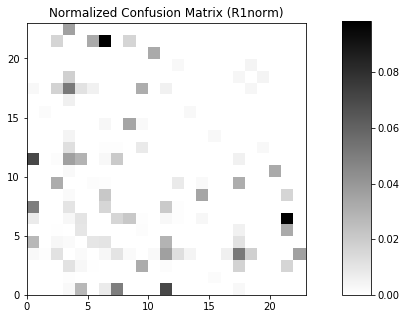

IGRAPH U-W- 23 0 --
+ attr: weight (e)
Converged!
m1: 0.098361
Accuracy: 0.956052
start_iter: 5
R1norm_cutoff: 0.088361
Accuracy: 0.956052
Round6 ...
Mean CV accuracy: 0.9614
Accuracy on the training set: 0.9904
Accuracy on the hold-out set: 0.9554


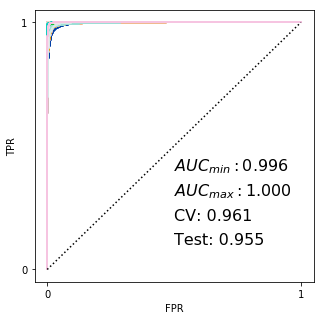

... storing 'L1_Round5_self-projection' as categorical


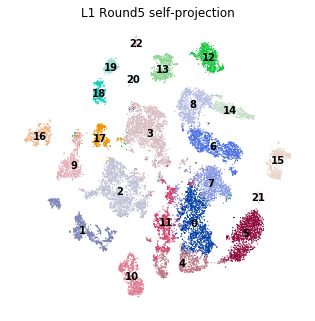

Accuracy on the training set: 0.9867
Accuracy on the hold-out set: 0.9592
Accuracy on the training set: 0.9867
Accuracy on the hold-out set: 0.9571
Max R1mat: 0.073654


<Figure size 360x360 with 0 Axes>

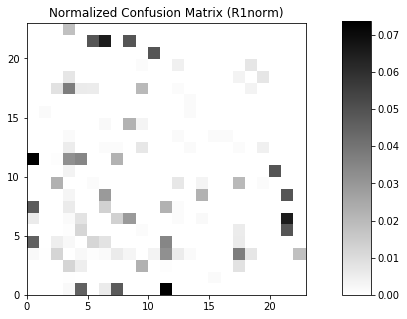

IGRAPH U-W- 23 0 --
+ attr: weight (e)
Converged!
m1: 0.073654
Accuracy: 0.955414
start_iter: 5
R1norm_cutoff: 0.063654
Accuracy: 0.955414
Round6 ...
Mean CV accuracy: 0.9660
Accuracy on the training set: 0.9876
Accuracy on the hold-out set: 0.9565


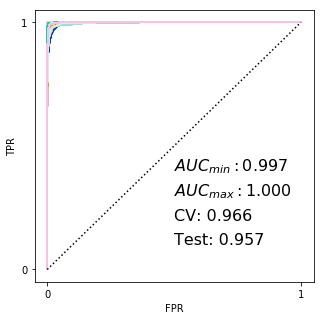

... storing 'L1_Round5_self-projection' as categorical


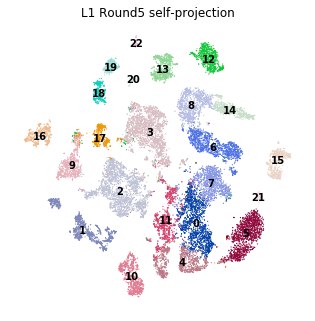

Accuracy on the training set: 0.9881
Accuracy on the hold-out set: 0.9573
Accuracy on the training set: 0.9899
Accuracy on the hold-out set: 0.9548
Max R1mat: 0.092888


<Figure size 360x360 with 0 Axes>

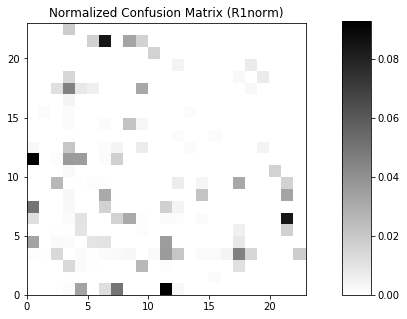

... storing 'L1_Round6' as categorical


IGRAPH U-W- 23 2 --
+ attr: weight (e)
+ edges:
0--11 0--11


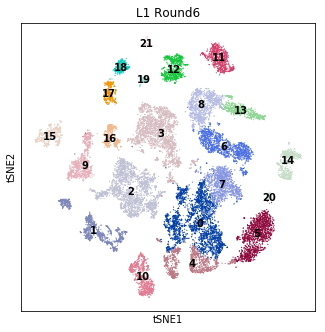

Round7 ...
Mean CV accuracy: 0.9750
Accuracy on the training set: 0.9937
Accuracy on the hold-out set: 0.9535


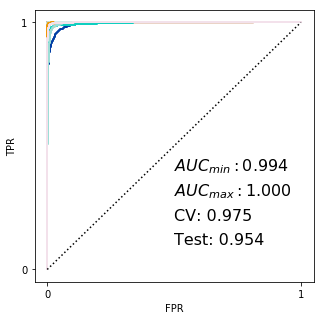

... storing 'L1_Round6_self-projection' as categorical


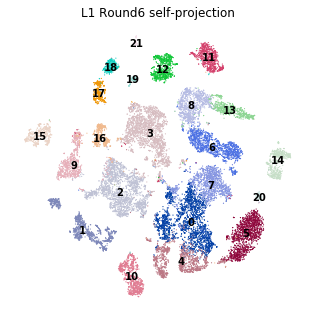

Accuracy on the training set: 0.9856
Accuracy on the hold-out set: 0.9578
Accuracy on the training set: 0.9870
Accuracy on the hold-out set: 0.9537
Max R1mat: 0.136041


<Figure size 360x360 with 0 Axes>

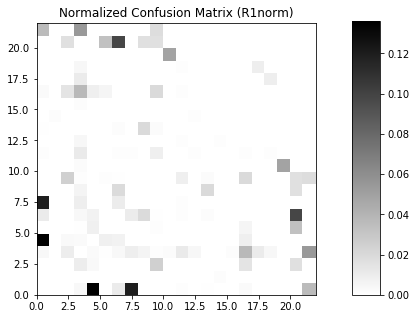

... storing 'L1_Round7' as categorical


IGRAPH U-W- 22 4 --
+ attr: weight (e)
+ edges:
0--4 0--7 0--4 0--7


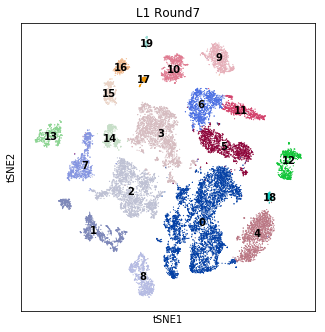

Round8 ...
Mean CV accuracy: 0.9803
Accuracy on the training set: 0.9963
Accuracy on the hold-out set: 0.9731


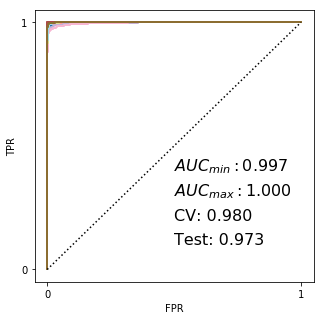

... storing 'L1_Round7_self-projection' as categorical


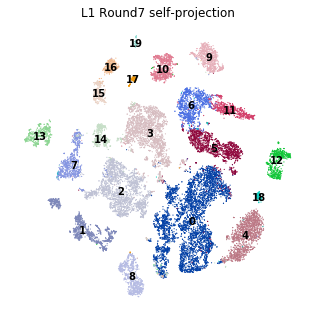

Accuracy on the training set: 0.9957
Accuracy on the hold-out set: 0.9744
Accuracy on the training set: 0.9925
Accuracy on the hold-out set: 0.9735
Max R1mat: 0.100000
Converge1!
m1: 0.100000
Accuracy: 0.973095


In [13]:
SCCAF_optimize_all(min_acc=0.96, ad=ad, use='pca', basis='tsne',key1 = 'louvain_r0.05')

In [14]:
ad.write("human/human_Glutamatergic_reg.h5")

In [43]:
ad = sc.read("human/human_Glutamatergic_reg.h5")

In [44]:
ad.uns['L1_result_colors'] = default_20

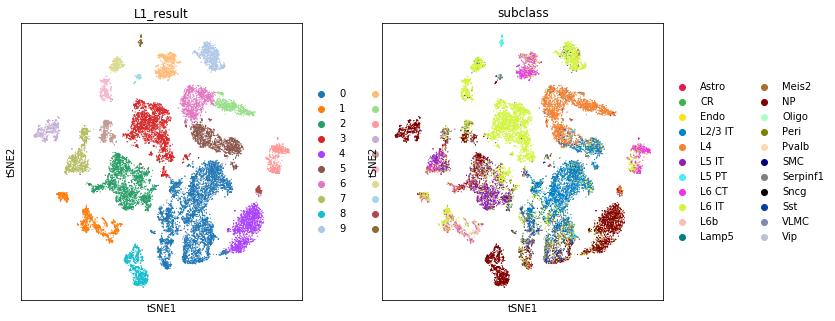

In [45]:
sc.pl.tsne(ad, color=['L1_result','subclass'])

> the data projection result is not ideal.

Mean CV accuracy: 0.5988
Accuracy on the training set: 0.9976
Accuracy on the hold-out set: 0.7053


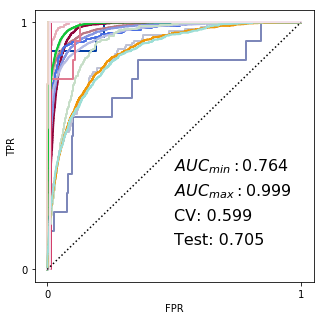

In [46]:
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(ad.X, ad.obs['subclass'],n=100)
aucs = plot_roc(y_prob, y_test, clf, cvsm=cvsm, acc=acc)
plt.show()

> the SCCAF optimized result shows better discrimination.

Mean CV accuracy: 0.9814
Accuracy on the training set: 0.9995
Accuracy on the hold-out set: 0.9724


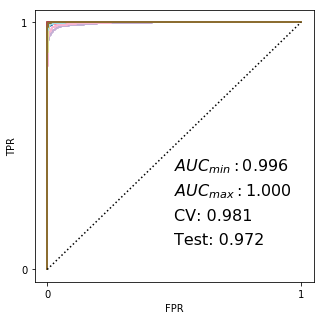

In [47]:
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(ad.X, ad.obs['L1_result'],n=100)
aucs = plot_roc(y_prob, y_test, clf, cvsm=cvsm, acc=acc)
plt.show()

In [48]:
topmarkers = get_topmarkers(clf, ad.var_names, topn=50)

In [49]:
topmarkers.to_csv("markers/Glutamatergic_markers.csv")

In [50]:
topmarkers = get_topmarkers(clf, ad.var_names, topn=2)

In [51]:
topmarkers

cell_type      gene    weight
2712          0    COL5A2  0.806696
1789          0      CA10  0.755640
9096          1     PCSK5  0.547003
6267          1     ITPR2  0.511961
12533        10      SYT6  1.211019
11269        10  SERPINE2  0.536071
4164         11      EYA4  0.773284
2180         11     CDH20  0.622437
12432        12     SULF1  0.967800
438          12  ADAMTSL1  0.630839
5855         13     HTR2C  1.279367
3146         13      DAB1  0.324426
944          14  ARHGAP15  0.894615
9192         14    PDZRN4  0.593918
10572        15     RGS12  1.168242
6249         15     ITGB8  0.900673
813          16     ANXA1  0.489371
5777         16     HPSE2  0.415998
11017        17     SAMD5  0.578276
12883        17    THSD7A  0.495773
13580        18     TSHZ2  0.641039
14666        18   ZNF804B  0.545390
5366         19      GRM8  0.598556
492          19    ADRA1A  0.352484
12949         2      TLL1  0.942018
9130          2     PDE4B  0.720963
8997          3    PARD3B  0.830191
2191          3      CDH9  0.714127
14136         4     VWC2L  0.684342
11681         4   SLC35F3  0.405838
12778         5    TESPA1  0.644786
7439          5     MEIS2  0.587085
12138         6    SPHKAP  1.171807
6034          6    IL1RAP  0.487385
9125          7     PDE1C  0.678559
4600          7      FMN1  0.546235
6231          8     ITGA8  0.493105
13888         8    UNC13C  0.474293
12865         9    THEMIS  0.853111
5852          9     HTR1F  0.474300

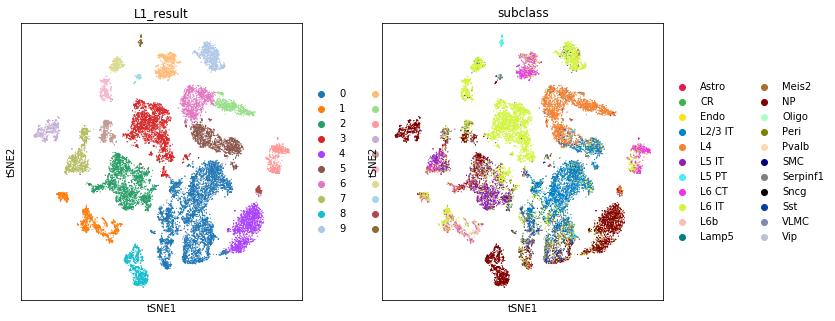

In [52]:
sc.pl.tsne(ad, color=['L1_result','subclass'])

In [53]:
key1 = 'L1_result'
key2 = 'subclass'
ad_obs = ad.obs
df = ad_obs.groupby([key1,key2]).size().to_frame().reset_index()
df.columns = [key1,key2,'counts']
df2 = ad_obs[key1].value_counts()
df['size'] = df2[df[key1].tolist()].tolist()
df['percent'] = df['counts']/df['size']
df = df[df['percent']>0.3]

In [54]:
df

L1_result subclass  counts  size   percent
3           0  L2/3 IT    2248  5251  0.428109
23          1    L6 IT     618  1213  0.509481
35          2    L5 IT     902  2524  0.357369
53          3    L6 IT    2334  2507  0.930993
70          4       NP    1341  1541  0.870214
77          5  L2/3 IT     464  1453  0.319339
78          5       L4     621  1453  0.427392
94          6       L4    1069  1139  0.938543
104         7    L5 IT     387   924  0.418831
115         8       NP     900   911  0.987925
122         9    L6 IT     752   828  0.908213
130        10    L6 CT     535   764  0.700262
134        11       L4     679   702  0.967236
141        12    L6 CT     438   687  0.637555
142        12    L6 IT     242   687  0.352256
149        13       NP     577   592  0.974662
154        14    L6 IT     175   455  0.384615
155        14       NP     167   455  0.367033
159        15    L6 IT     364   373  0.975871
163        16    L6 IT     306   324  0.944444
173        18       L4      82   122  0.672131
177        18       NP      37   122  0.303279
179        19    L5 PT     107   110  0.972727

In [64]:
key1 = 'L1_result'
key2 = 'brain_subregion'
ad_obs = ad.obs
df = ad_obs.groupby([key1,key2]).size().to_frame().reset_index()
df.columns = [key1,key2,'counts']
df2 = ad_obs[key1].value_counts()
df['size'] = df2[df[key1].tolist()].tolist()
df['percent'] = df['counts']/df['size']
df = df[df['percent']>0.1]

In [65]:
df

L1_result brain_subregion  counts  size   percent
1           0              L2    1186  5251  0.225862
2           0            L2_3     991  5251  0.188726
3           0              L3    1910  5251  0.363740
13          1              L5     155  1213  0.127782
15          1              L6     726  1213  0.598516
16          1             L6a     157  1213  0.129431
17          1             L6b     143  1213  0.117890
22          2              L4     760  2524  0.301109
25          2              L5     923  2524  0.365689
26          2             L5a     266  2524  0.105388
36          3              L5     364  2507  0.145193
39          3              L6    1835  2507  0.731951
49          4              L3     261  1541  0.169371
50          4              L4     877  1541  0.569111
52          4              L5     363  1541  0.235561
56          5              L1     199  1453  0.136958
57          5              L2     440  1453  0.302822
59          5              L3     437  1453  0.300757
61          5            L4ab     349  1453  0.240193
68          6            L4ab     275  1139  0.241440
69          6             L4c     653  1139  0.573310
70          6              L5     126  1139  0.110623
75          7             L4c     350   924  0.378788
76          7              L5     324   924  0.350649
79          7             L6a     145   924  0.156926
83          8            MC-a     224   911  0.245884
84          8            MC-p     174   911  0.190999
85          8            PC-a     232   911  0.254665
86          8            PC-p     155   911  0.170143
90          9              L5     110   828  0.132850
93          9             L6a     479   828  0.578502
94          9             L6b     219   828  0.264493
96         10              L5     128   764  0.167539
98         10             L6a     329   764  0.430628
99         10             L6b     298   764  0.390052
102        11             L4c     468   702  0.666667
103        11              L5     146   702  0.207977
109        12              L5      93   687  0.135371
112        12              L6     515   687  0.749636
122        13              L5     255   592  0.430743
124        13             L5b      84   592  0.141892
125        13              L6     157   592  0.265203
132        14              L5     241   455  0.529670
134        14             L5b      66   455  0.145055
135        14              L6      83   455  0.182418
139        15              L5     186   373  0.498660
142        15              L6     145   373  0.388740
147        16              L5     126   324  0.388889
149        16             L6a     125   324  0.385802
150        16             L6b      47   324  0.145062
152        17            KC-p      26   122  0.213115
153        17            MC-a      13   122  0.106557
156        17            PC-p      72   122  0.590164
158        18            L4ab      31   122  0.254098
159        18             L4c      85   122  0.696721
164        19              L5      19   110  0.172727
166        19             L5b      51   110  0.463636
167        19              L6      12   110  0.109091

In [59]:
ad.uns['brain_subregion_colors'] = default_20

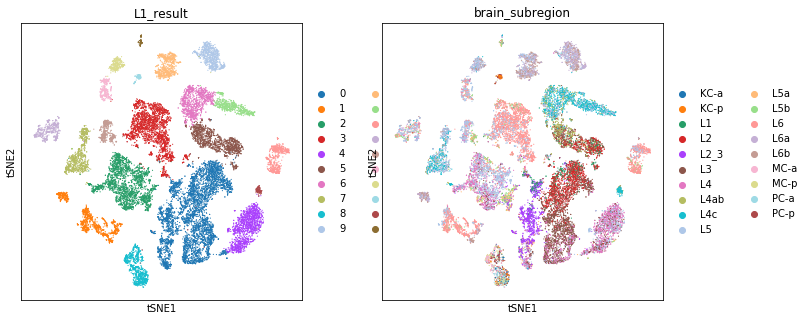

In [61]:
sc.pl.tsne(ad, color=['L1_result','brain_subregion'])

|SCCAF|subclass|
|-|-|
|0|L2/3|
|1|L6|
|2|L4/5|
|3|L6|
|4|L4/5|
|5|L2/3/4ab|
|6|L4abc|
|7|L4c/5|
|8|MC/PC|
|9|L6ab/5|
|10|L6ab/5|
|11|L4c/5|
|12|L6|
|13|L5/6|
|14|L5/6|
|15|L5/6|
|16|L5/6ab|
|17|KC/MC/PC|
|18|L4abc|
|19|L5/6|

> combine the projection markers and the SCCAF extracted markers to annotate the `subclass`.

In [51]:
topmarkers

cell_type      gene    weight
2712          0    COL5A2  0.806696
1789          0      CA10  0.755640
9096          1     PCSK5  0.547003
6267          1     ITPR2  0.511961
12533        10      SYT6  1.211019
11269        10  SERPINE2  0.536071
4164         11      EYA4  0.773284
2180         11     CDH20  0.622437
12432        12     SULF1  0.967800
438          12  ADAMTSL1  0.630839
5855         13     HTR2C  1.279367
3146         13      DAB1  0.324426
944          14  ARHGAP15  0.894615
9192         14    PDZRN4  0.593918
10572        15     RGS12  1.168242
6249         15     ITGB8  0.900673
813          16     ANXA1  0.489371
5777         16     HPSE2  0.415998
11017        17     SAMD5  0.578276
12883        17    THSD7A  0.495773
13580        18     TSHZ2  0.641039
14666        18   ZNF804B  0.545390
5366         19      GRM8  0.598556
492          19    ADRA1A  0.352484
12949         2      TLL1  0.942018
9130          2     PDE4B  0.720963
8997          3    PARD3B  0.830191
2191          3      CDH9  0.714127
14136         4     VWC2L  0.684342
11681         4   SLC35F3  0.405838
12778         5    TESPA1  0.644786
7439          5     MEIS2  0.587085
12138         6    SPHKAP  1.171807
6034          6    IL1RAP  0.487385
9125          7     PDE1C  0.678559
4600          7      FMN1  0.546235
6231          8     ITGA8  0.493105
13888         8    UNC13C  0.474293
12865         9    THEMIS  0.853111
5852          9     HTR1F  0.474300

In [66]:
x = '''L2/3 COL5A2 CA10
L6 PCSK5 ITPR2
L4/5 TLL1 PDE4B
L6 PARD3B CDH9
L4/5 VWC2L SLC35F3
L2/3/4ab TESPA1 MEIS2
L4abc SPHKAP
L4c/5 PDE1C FMN1
MC/PC ITGA8
L6ab/5 THEMIS
L6ab/5 SYT6 SERPINE2
L4c/5 EYA4 CDH20
L6 SULF1 ADAMTSL1
L5/6 HTR2C
L5/6 ARHGAP15 PDZRN4
L5/6 RGS12 ITGB8
L5/6ab ANXA1
KC/MC/PC SAMD5
L4abc TSHZ2 ZNF804B
L5/6 GRM8'''.split('\n')

In [67]:
ad.obs['ann'] = ad.obs['L1_result']
ad.obs['ann'].cat.categories = x

In [68]:
ad.uns['ann_colors'] = default_20

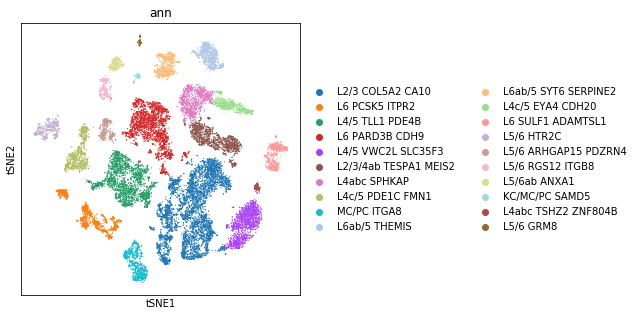

In [69]:
sc.pl.tsne(ad, color=['ann'])

In [70]:
ad.write("human/human_Glutamatergic_reg.h5")

## Non-Neuronal

In [18]:
ad = sc.read("human/human_Non-Neuronal.h5")

In [19]:
import pickle
clf = pickle.load(open('subclass.pickle','rb'))

In [20]:
ad.obs['subclass'] = clf.predict(ad.X)

... storing 'subclass' as categorical


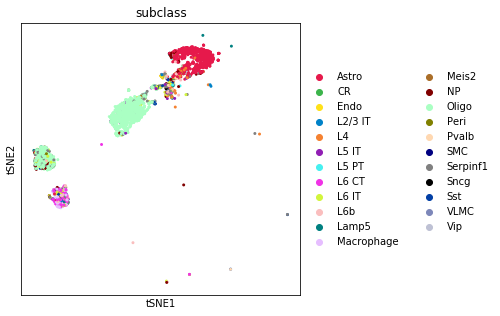

In [21]:
figsize(5,5)
sc.pl.tsne(ad, color=['subclass'])

In [22]:
sc.tl.pca(ad, svd_solver='arpack')
sc.pp.neighbors(ad)
sc.tl.tsne(ad)

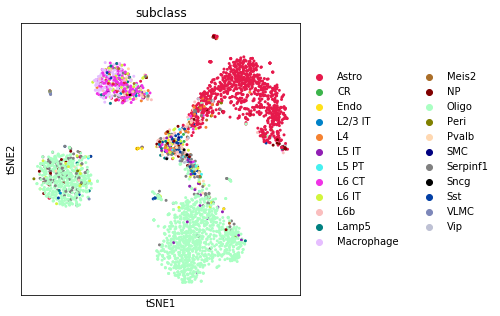

In [23]:
sc.pl.tsne(ad, color=['subclass'])

In [24]:
sc.tl.louvain(ad, resolution=0.05, key_added='louvain_r0.05')
sc.tl.louvain(ad, resolution=0.2, key_added='louvain_r0.2')
sc.tl.louvain(ad, resolution=0.3, key_added='louvain_r0.3')
sc.tl.louvain(ad, resolution=0.5, key_added='louvain_r0.5')
sc.tl.louvain(ad, resolution=1, key_added='louvain_r1')

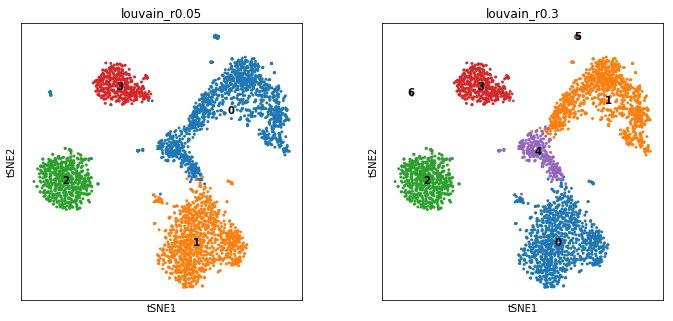

In [33]:
sc.pl.tsne(ad, color=['louvain_r0.05','louvain_r0.3'],legend_loc='on data')

In [34]:
ad.obs['L1_Round0'] = ad.obs['louvain_r0.3']

start_iter: 0
R1norm_cutoff: 0.500000
Accuracy: 0.000000
Round1 ...
Mean CV accuracy: 0.9866
Accuracy on the training set: 0.9943
Accuracy on the hold-out set: 0.9889


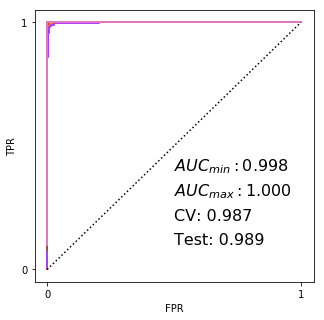

... storing 'L1_Round0_self-projection' as categorical


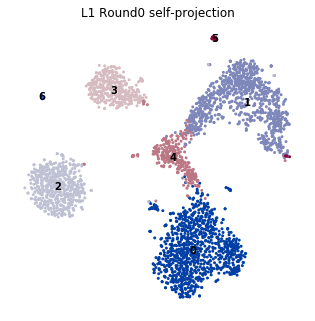

Accuracy on the training set: 0.9962
Accuracy on the hold-out set: 0.9858
Accuracy on the training set: 0.9981
Accuracy on the hold-out set: 0.9841
Max R1mat: 0.061611
Converge1!
c: 1
m1: 0.061611
Accuracy: 0.984061


In [35]:
SCCAF_optimize_all_V2(min_acc=0.96, ad=ad, use='pca', basis='tsne',key1 = 'louvain_r0.05')

In [36]:
ad.write("human/human_Non-Neuronal_reg.h5")

In [71]:
ad = sc.read("human/human_Non-Neuronal_reg.h5")

In [72]:
ad.uns['L1_result_colors'] = default_20

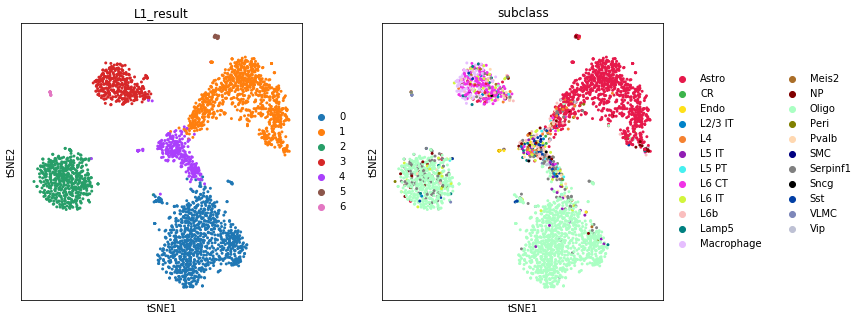

In [73]:
sc.pl.tsne(ad, color=['L1_result','subclass'])

> the data projection result is not ideal.

Mean CV accuracy: 0.5324
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.7927


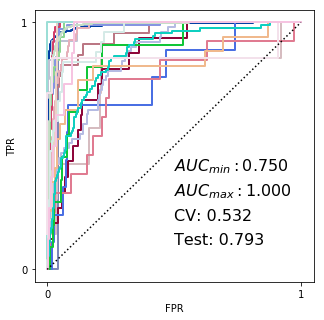

In [74]:
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(ad.X, ad.obs['subclass'],n=100)
aucs = plot_roc(y_prob, y_test, clf, cvsm=cvsm, acc=acc)
plt.show()

> the SCCAF optimized result shows better discrimination.

Mean CV accuracy: 0.9713
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.9799


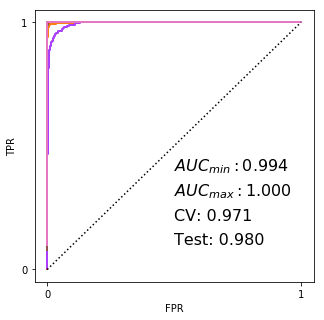

In [75]:
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(ad.X, ad.obs['L1_result'],n=100)
aucs = plot_roc(y_prob, y_test, clf, cvsm=cvsm, acc=acc)
plt.show()

In [76]:
topmarkers = get_topmarkers(clf, ad.var_names, topn=50)

In [77]:
topmarkers.to_csv("markers/Non-Neuronal_markers.csv")

In [78]:
topmarkers = get_topmarkers(clf, ad.var_names, topn=2)

In [79]:
topmarkers

cell_type     gene    weight
12280         0     ST18  0.608603
13895         0    UNC5C  0.283273
3582          1    DPP10  0.447188
10976         1     RYR3  0.405164
6826          2   LHFPL3  0.529590
1789          2     CA10  0.354378
2112          3     CD74  0.488745
824           3     AOAH  0.380240
3461          4   DNAH17  0.713156
4244          4  FAM155A  0.476263
6822          5     LGR6  1.093244
13250         5      TNC  0.686053
3209          6      DCN  0.647028
6709          6    LAMA2  0.569162

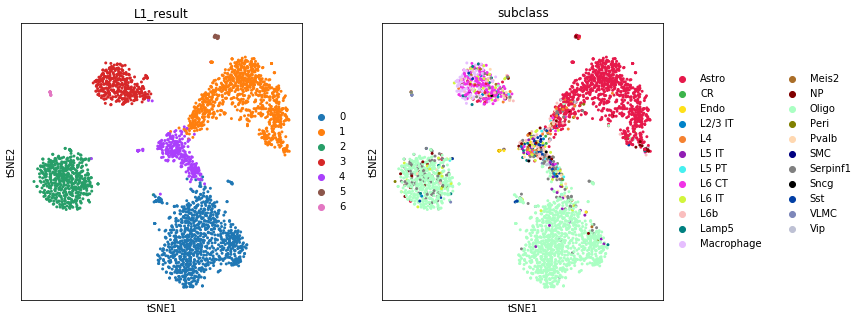

In [80]:
sc.pl.tsne(ad, color=['L1_result','subclass'])

In [85]:
key1 = 'L1_result'
key2 = 'subclass'
ad_obs = ad.obs
df = ad_obs.groupby([key1,key2]).size().to_frame().reset_index()
df.columns = [key1,key2,'counts']
df2 = ad_obs[key1].value_counts()
df['size'] = df2[df[key1].tolist()].tolist()
df['percent'] = df['counts']/df['size']
df = df[df['percent']>0.1]

In [86]:
df

L1_result    subclass  counts  size   percent
9          0       Oligo    1006  1080  0.931481
14         1       Astro     882  1000  0.882000
40         2       Oligo     426   560  0.760714
43         2    Serpinf1      79   560  0.141071
51         3       L6 CT     144   406  0.354680
55         3  Macrophage     101   406  0.248768
71         4       L6 IT      36   317  0.113565
72         4         L6b      43   317  0.135647
80         4    Serpinf1      39   317  0.123028
85         5       Astro      16    26  0.615385
87         5          NP       8    26  0.307692
91         6    Serpinf1       5    20  0.250000
92         6        VLMC      11    20  0.550000

In [83]:
ad.uns['brain_subregion_colors'] = default_20

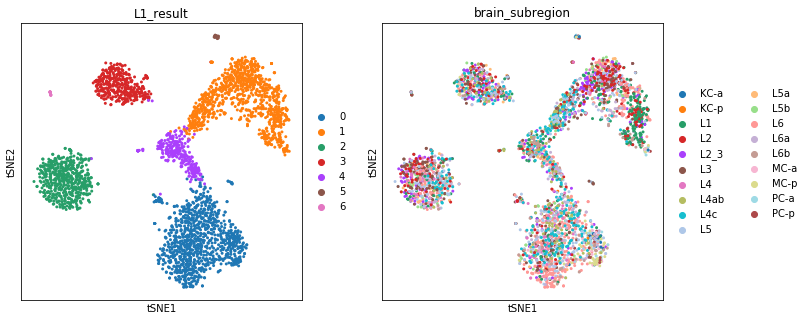

In [84]:
sc.pl.tsne(ad, color=['L1_result','brain_subregion'])

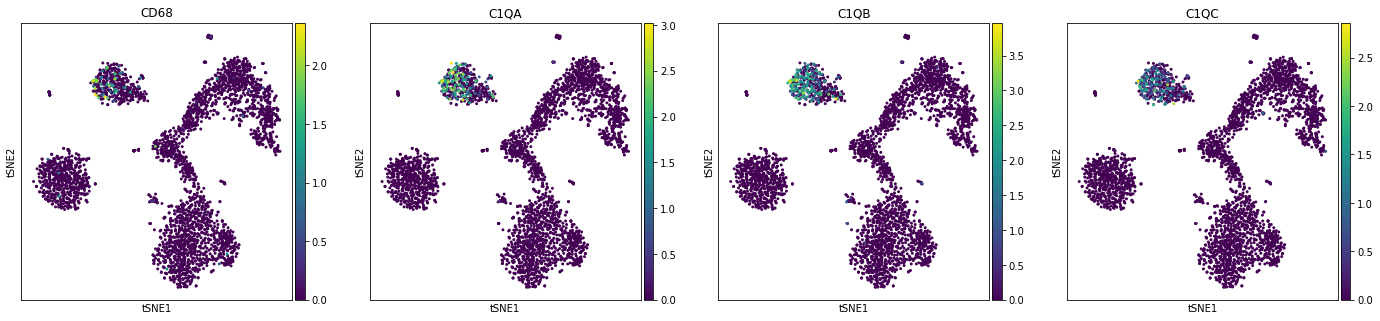

In [89]:
sc.pl.tsne(ad, color=['CD68','C1QA','C1QB','C1QC'])

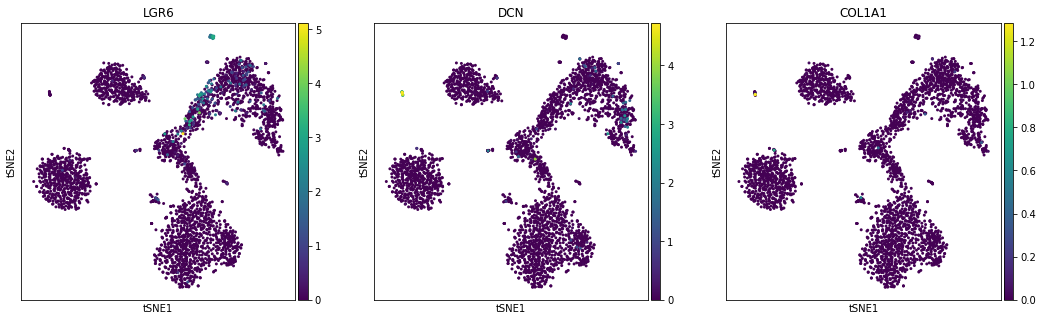

In [96]:
sc.pl.tsne(ad, color=['LGR6','DCN','COL1A1'])

|SCCAF|subclass|
|-|-|
|0|Oligo|
|1|Astro|
|2|Oligo|
|3|Macrophage|
|4|mixed|
|5|Astro|
|6|Stellate|

> combine the projection markers and the SCCAF extracted markers to annotate the `subclass`.

In [79]:
topmarkers

cell_type     gene    weight
12280         0     ST18  0.608603
13895         0    UNC5C  0.283273
3582          1    DPP10  0.447188
10976         1     RYR3  0.405164
6826          2   LHFPL3  0.529590
1789          2     CA10  0.354378
2112          3     CD74  0.488745
824           3     AOAH  0.380240
3461          4   DNAH17  0.713156
4244          4  FAM155A  0.476263
6822          5     LGR6  1.093244
13250         5      TNC  0.686053
3209          6      DCN  0.647028
6709          6    LAMA2  0.569162

In [97]:
x = '''Oligo ST18
Astro DPP10
Oligo LHFPL3
Macrophage CD74
mixed DNAH17
Astro LGR6 TNC
Stellate DCN LAMA2'''.split('\n')

In [98]:
ad.obs['ann'] = ad.obs['L1_result']
ad.obs['ann'].cat.categories = x

In [99]:
ad.uns['ann_colors'] = default_20

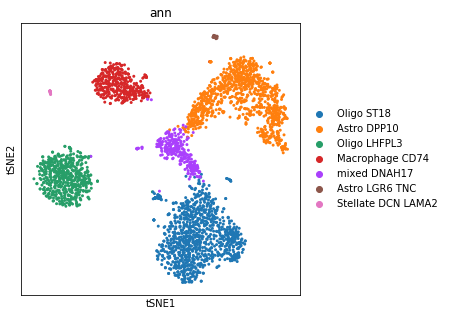

In [100]:
sc.pl.tsne(ad, color=['ann'])

In [101]:
ad.write("human/human_Non-Neuronal_reg.h5")

# Annotate

... storing 'ann1' as categorical


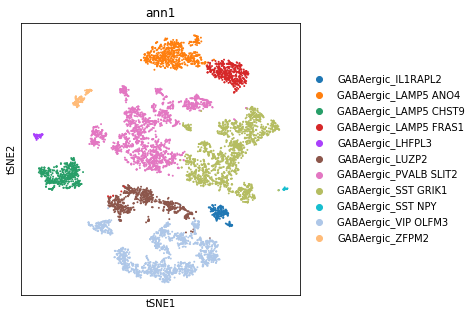

... storing 'ann1' as categorical


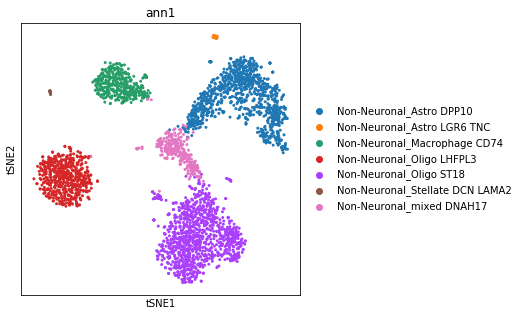

... storing 'ann1' as categorical


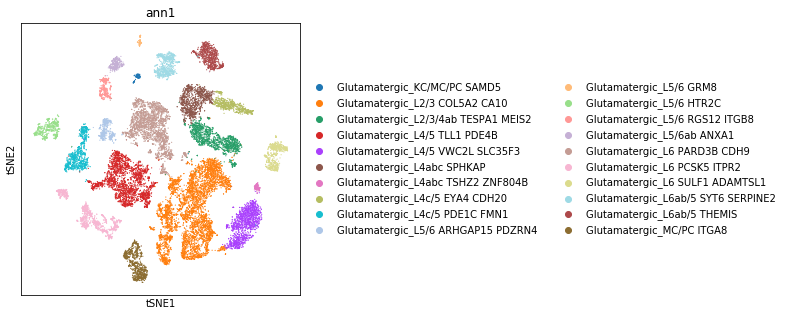

In [102]:
for prefix in ['GABAergic', 'Non-Neuronal', 'Glutamatergic']:
    ad = sc.read("human/human_%s_reg.h5"%prefix)
    ad.obs['ann1'] = ['%s_%s'%(prefix,i) for i in ad.obs['ann'].tolist()]
    ad.uns['ann1_colors'] = default_20
    sc.pl.tsne(ad, color=['ann1'])
    ad.write("human/human_%s_reg.h5"%prefix)

In [103]:
dfs = []
for prefix in ['GABAergic', 'Non-Neuronal', 'Glutamatergic']:
    ad = sc.read("human/human_%s_reg.h5"%prefix)
    df = ad.obs['ann1']
    dfs.append(df)

In [104]:
ad.shape

(22542, 14780)

In [105]:
dfs[2].shape

(22542,)

In [106]:
df = pd.concat(dfs, axis=0)

In [107]:
ad = sc.read("hh.h5")

In [108]:
ad.obs['ann1'] = df.loc[ad.obs_names]

... storing 'ann1' as categorical


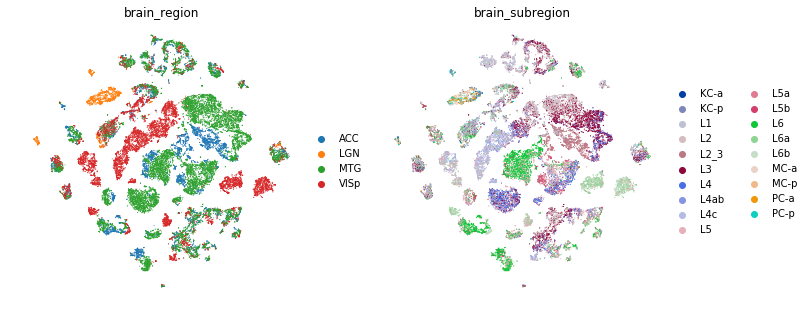

In [109]:
sc.pl.tsne(ad, color=['brain_region','brain_subregion'], frameon=False)

In [110]:
len(ad.obs['ann1'].unique())

38

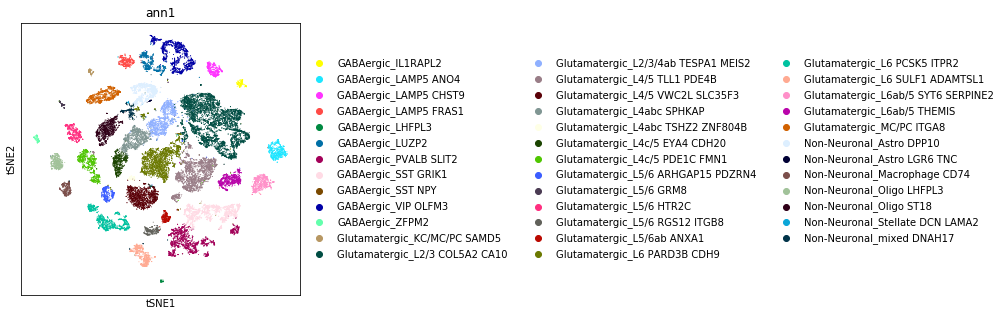

In [111]:
sc.pl.tsne(ad, color=['ann1'])

In [112]:
df = pd.read_csv("color.csv",index_col=0,header=None)
ad.uns['ann1_colors'] = df.index

saving figure to file ./figures/tsnecluster.pdf


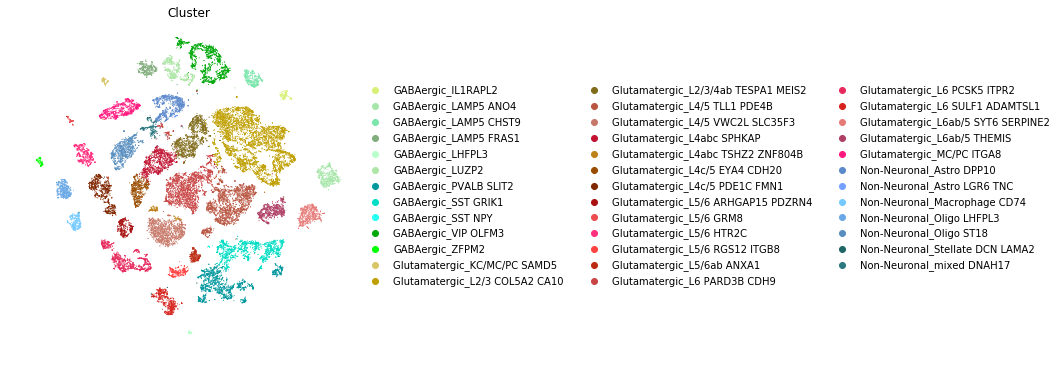

In [113]:
figsize(6,6)
sc.pl.tsne(ad, color=['ann1'], title ='Cluster',frameon=False, save='cluster.pdf')

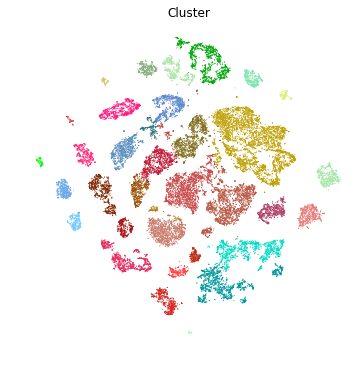

In [114]:
figsize(6,6)
sc.pl.tsne(ad, color=['ann1'], title ='Cluster',frameon=False,legend_loc='')

saving figure to file ./figures/tsnebrain_region.pdf


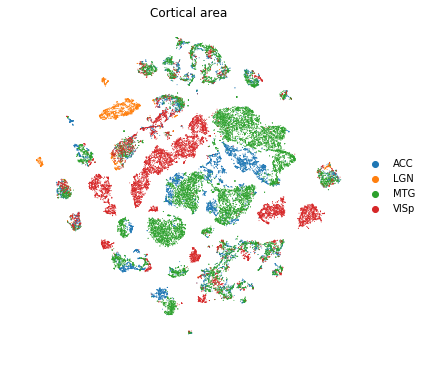

In [115]:
figsize(6,6)
sc.pl.tsne(ad, color=['brain_region'], title ='Cortical area',frameon=False, save='brain_region.pdf')

In [116]:
ad.uns['class1_colors'] = ['#FF2F7E','#0f80f5','#939598']
ad.obs['class1'] = ad.obs['ann1'].str.split('_').str[0]

... storing 'class1' as categorical


saving figure to file ./figures/tsneClass.pdf


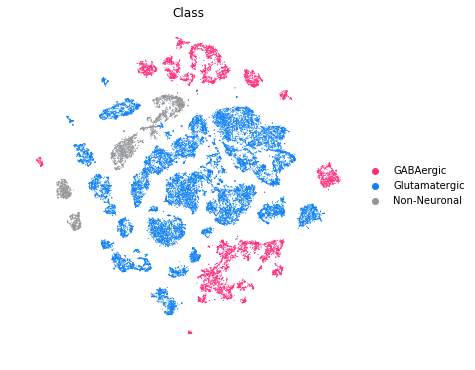

In [117]:
figsize(6,6)
sc.pl.tsne(ad, color=['class1'], title ='Class',frameon=False, save='Class.pdf')

In [118]:
ad.write("hh.h5")

Mean CV accuracy: 0.9692
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.9709


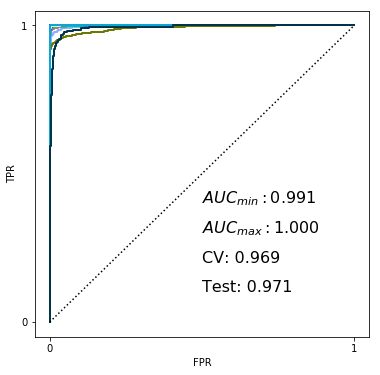

In [119]:
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(ad.X, ad.obs['ann1'],n=100)
aucs = plot_roc(y_prob, y_test, clf, cvsm=cvsm, acc=acc)
plt.show()

In [120]:
topmarkers = get_topmarkers(clf, ad.var_names, topn=100)

In [121]:
topmarkers.to_csv("markers/topmarkers.csv")

In [122]:
topmarkers.head(2)

cell_type   gene    weight
8639   GABAergic_IL1RAPL2  NXPH1  0.570044
10514  GABAergic_IL1RAPL2   RELN  0.561654

In [126]:
topmarkers = get_topmarkers(clf, ad.var_names, topn=1)

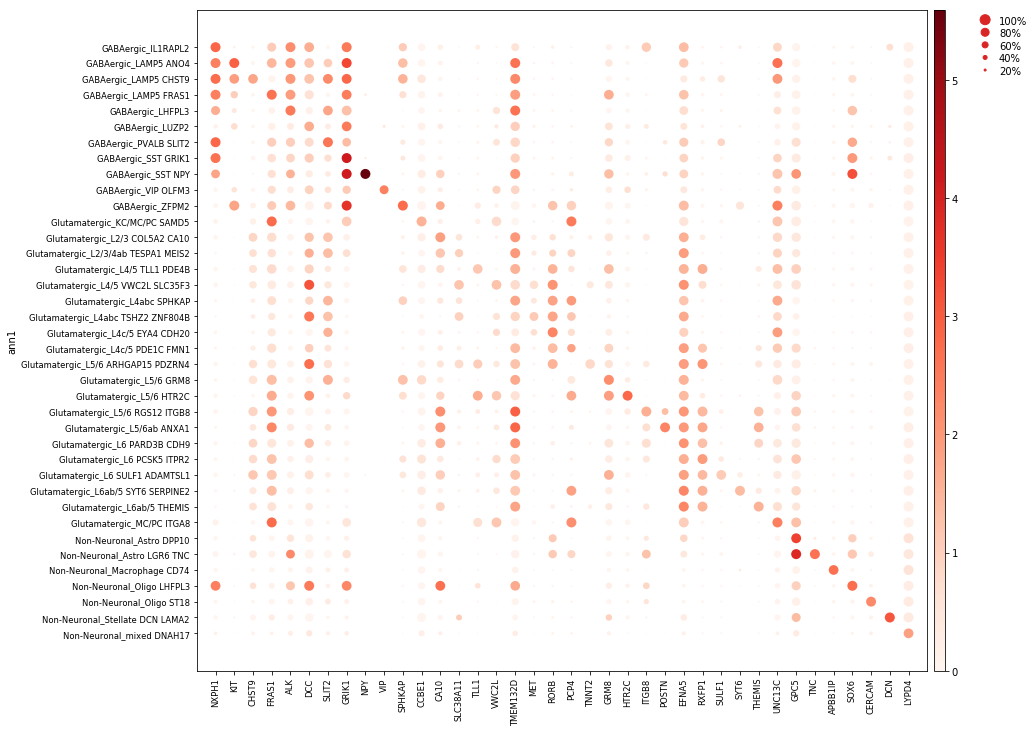

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[13.299999999999999, 0, 0.2, 0.5, 0.25])

In [127]:
sc.pl.dotplot(ad, var_names=topmarkers.gene, groupby='ann1')

In [123]:
topmarkers = get_topmarkers(clf, ad.var_names, topn=2)

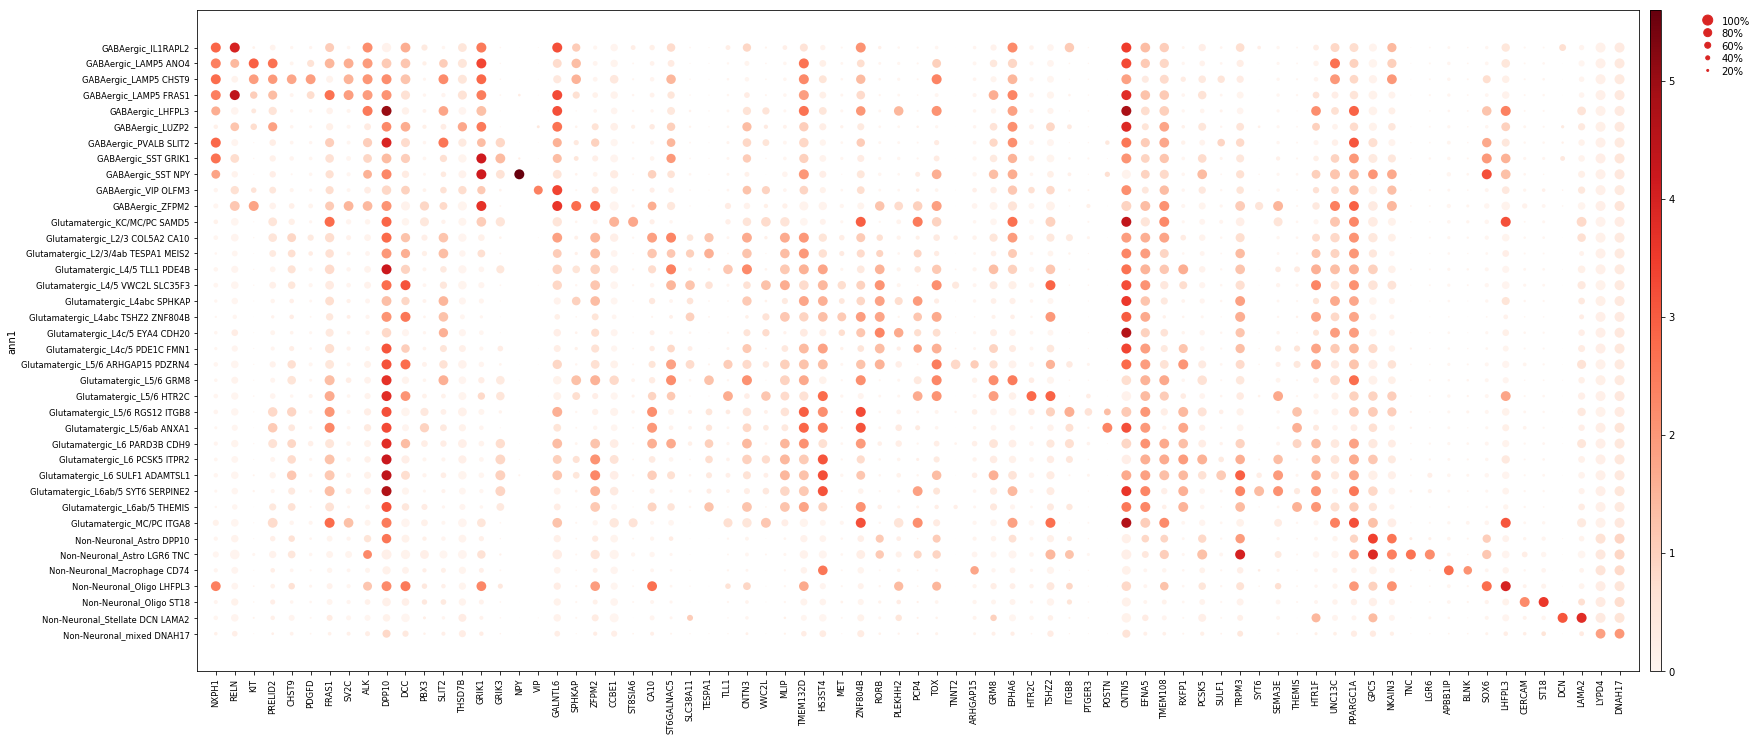

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[26.25, 0, 0.2, 0.5, 0.25])

In [124]:
sc.pl.dotplot(ad, var_names=topmarkers.gene, groupby='ann1')

In [128]:
topmarkers = get_topmarkers(clf, ad.var_names, topn=3)

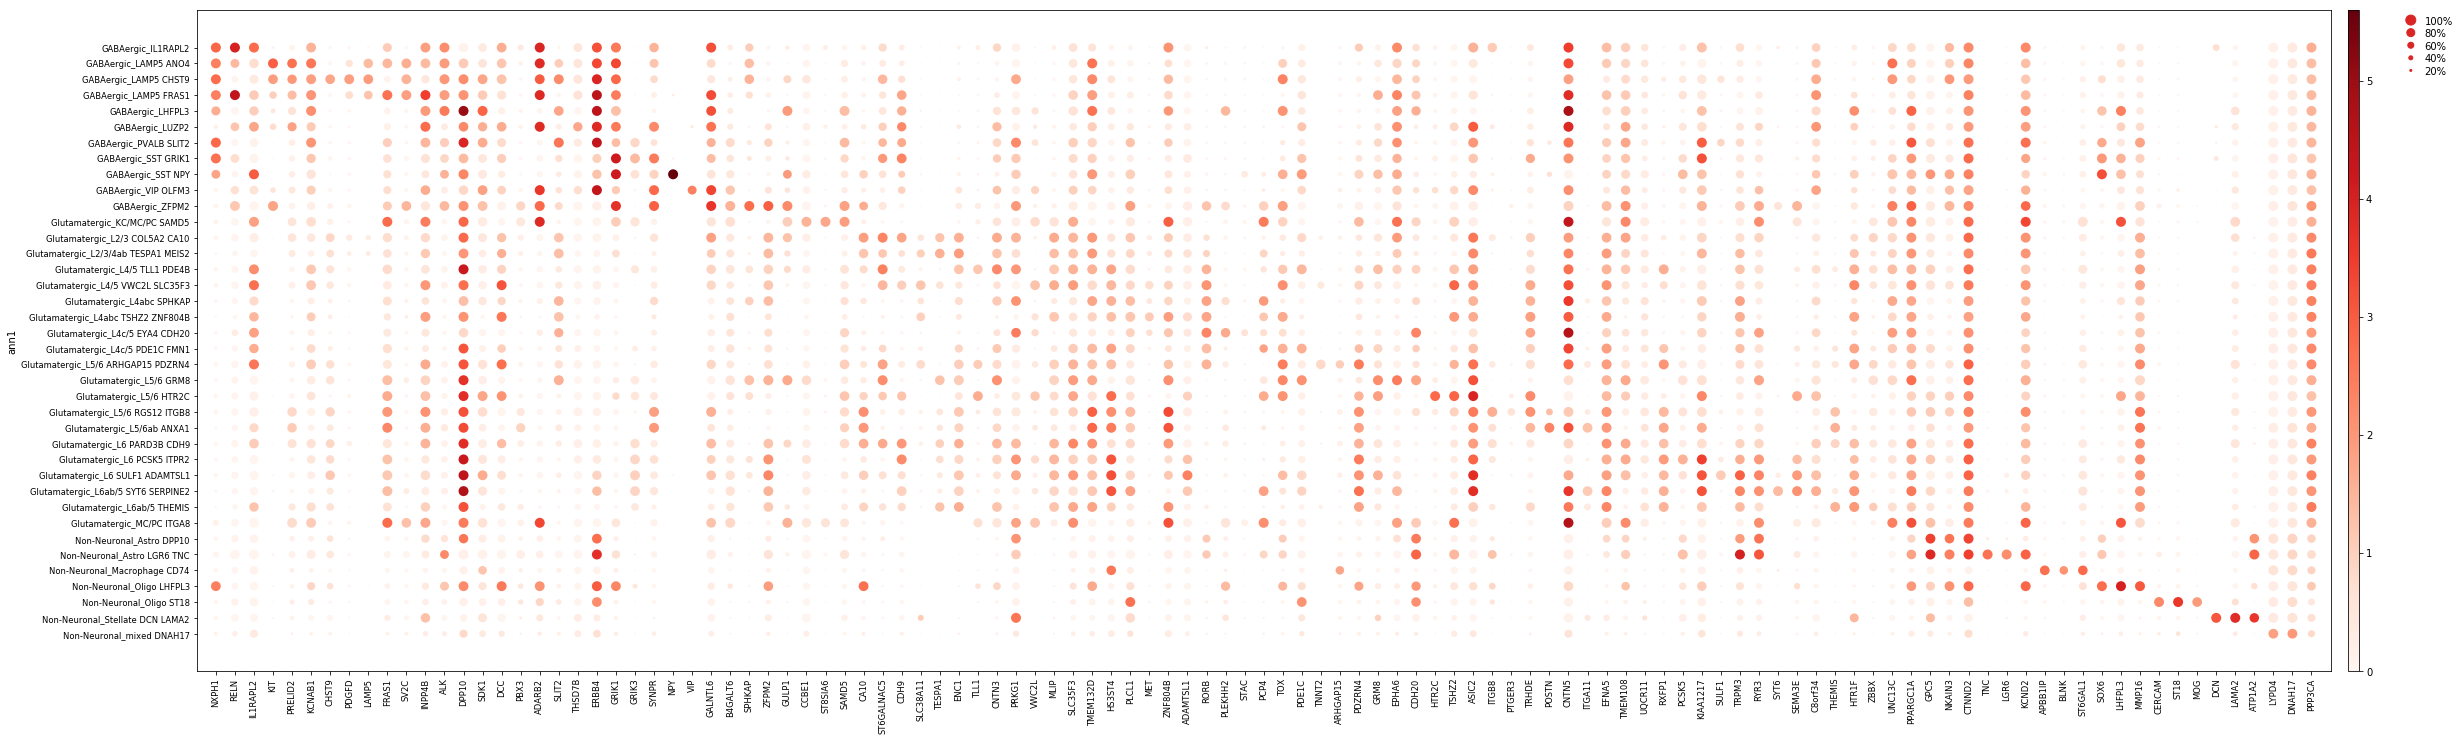

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[38.849999999999994, 0, 0.2, 0.5, 0.25])

In [129]:
sc.pl.dotplot(ad, var_names=topmarkers.gene, groupby='ann1')

# End